# Eniac

## 1.Importing Data

Turning them into a dictionary of dataframes.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from collections import Counter
from itertools import combinations

orders_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orders_clean.parquet"
orderlines_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orderlines_clean.parquet"
products_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/products_clean.parquet"
brands_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/brands_clean.parquet"

# Loading dataframes directly from GitHub
orders_df = pd.read_parquet(orders_url)
orderlines_df = pd.read_parquet(orderlines_url)
products_df = pd.read_parquet(products_url)
brands_df = pd.read_parquet(brands_url)

orders = orders_df.copy()
orderlines = orderlines_df.copy()
products = products_df.copy()
brands = brands_df.copy()

Set Display Formats of Pandas

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 200)

## 2. Data Integration

### 2.1 Mergers and logical combinations

In [3]:
# Rename column to match with orders (better readability)
orderlines.rename(columns={'id_order': 'order_id'}, inplace=True)
orderlines['short'] = orderlines['sku'].str[:3]

In [4]:
oo = orders.merge(orderlines, on='order_id', how='left')
boo = oo.merge(brands, on='short', how='right')

Delete oders where there is one or more products, which are not identified. 
1.make a list of all known products (products table). Go into the orders, orderlines, brands table and exclude orders whose id is not in that list. Lastly merge the products table onto the boo table.

In [5]:
known_products = products['sku']
orders_with_unknown_products = boo.loc[~boo.sku.isin(known_products), "order_id"]
boo = boo.loc[~boo["order_id"].isin(orders_with_unknown_products), :]
df = boo.merge(products, on ='sku', how='left')

### 2.2 Create new columns

#### 2.2.1 Boolean Promotion and Promo_price

Create a boolean condition which is true when a promotion was applied on the price.

In [6]:
df['price_promotion'] = df['unit_price'] < df['price']
df['promo_price'] = df.apply(lambda row: row['unit_price'] if row['price_promotion'] else np.nan, axis=1)
df[['promo_price','price_promotion', 'price']].head()

,promo_price,price_promotion,price
0,23.99,True,35.00
1,23.99,True,35.00
2,23.99,True,35.00
3,23.99,True,35.00
4,23.99,True,35.00


#### 2.2.2 order_price

Use this price to compare to the total paid, to infer knowledge about shipping costs etc.

In [7]:
df['unit_price_total'] = df['product_quantity'] * df['unit_price']
order_total_price = df.groupby('order_id')['unit_price_total'].sum().reset_index()
order_total_price.rename(columns={'unit_price_total': 'order_price'}, inplace=True)
df = df.merge(order_total_price, on='order_id')

#### 2.2.3 Orders with at least one promotional item

In [8]:
df['order_inc_promo'] = df.groupby('order_id')['price_promotion'].transform('any')
df['order_inc_promo'].value_counts()

True     262211
False     15415
Name: order_inc_promo, dtype: int64

#### 2.2.4 Difference between total_paid and order_price

Look at the difference between what was paid and what the products inside the order combined cost. Do this only for completed orders. This might give us insight about promotions on the entire order (10% on your entire oder) or shipping costs. We can also exclude outliers from this, since there might be some corrupted data.

In [9]:
df['diff_paid_totalprice'] = df['total_paid'] - df['order_price']

#### 2.2.5 Promotion Percentage per Product

In [10]:
df['promo_perc'] = (1-(df['unit_price']/df['price']))

#### 2.2.6 More date types to access

In [11]:
df[['year', 'week', 'day']]= df['created_date'].dt.isocalendar()
# Extract month and quarter
df['month'] = df['created_date'].dt.month
df['quarter'] = df['created_date'].dt.quarter

#### 2.2.6 Price categories

In [12]:
df['price_category'] = np.nan

# Assigning categories based on conditions
df.loc[(df.unit_price <= 30), 'price_category']  = '0-30'
df.loc[(df.unit_price  > 30) & (df.unit_price  <= 50), 'price_category']  = '30-50'
df.loc[(df.unit_price  > 50) & (df.unit_price  <= 100), 'price_category']  = '50-100'
df.loc[(df.unit_price  > 100) & (df.unit_price  <= 200), 'price_category']  = '100-200'
df.loc[(df.unit_price  > 200) & (df.unit_price  <= 500), 'price_category']  = '200-500'
df.loc[(df.unit_price  > 500) & (df.unit_price  <= 1500), 'price_category']  = '500-1500'
df.loc[df.unit_price  > 1500, 'price_category'] = '1500+'

# Sampling the results
print(df[['price_category', 'unit_price']].sample(10))

       price_category  unit_price
162391        100-200      183.99
69312         100-200      164.99
109735         50-100       64.99
218256        100-200      183.99
42630          50-100       56.00
250498        100-200      125.99
258276           0-30        7.99
139531        100-200      139.98
18286         200-500      229.00
198281           0-30        8.99


#### 2.2.7 Promo Price difference monetary

In [13]:
df['promo_in_monetary'] = (df['price'] - df['unit_price'])*df['product_quantity']

In [14]:
df.head(1)

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary
0,343034,2017-04-04 10:47:28,23.99,Shopping Basket,1.00,8MO0008,23.99,2017-04-04 10:47:28,8MO,8Mobility,8Mobility iSlice Micro SD Adapter Macbook Pro ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,False,12585395,True,23.99,23.99,23.99,True,0.00,0.31,2017,14,2,4,2,0-30,11.01


#### 2.2.8 Number Items per Order

In [15]:
nr_items_per_order = df.groupby('order_id')['product_quantity'].sum()
nr_items_per_order.rename('quantity_per_order', inplace=True)
df = df.merge(nr_items_per_order, on= 'order_id', how='left')

#### 2.2.9 Join all products per order into one column

In [16]:
df['grouped'] = df.groupby('order_id')['name'].transform(lambda x: ','.join(x))
df['grouped_unit_prices'] = df.groupby('order_id')['unit_price'].transform(lambda x: ','.join(map(str, x)))
df['grouped_prices'] = df.groupby('order_id')['price'].transform(lambda x: ','.join(map(str, x)))

### 2.3 Outliers

When checking the unit_price, price and total_paid there might be statistically some outliers, but some products are extremely expensive and therefore, should still be utilised. Howeever, there can be some outliers in the difference between what was paid and the value of that order. These should be excluded, since they can show corrupted data. Let's do this here.

#### 2.3.1 Unit_price 

Let me check the unit_price, the total_paid and the order_price and remove outliers. In the step below I deleted negative prices. Here I want to confine our dataframe into prices that are normal/ usable for promotions. 

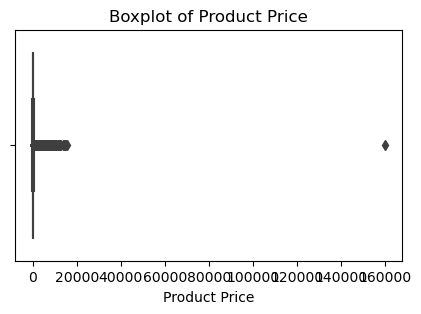

In [17]:
plt.figure(figsize=(5,3))
sns.boxplot(x=df['unit_price'])
plt.title('Boxplot of Product Price')
plt.xlabel('Product Price')
plt.show()

In [18]:
Q1 = df['unit_price'].quantile(0.25)
Q3 = df['unit_price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['unit_price'] < lower_bound) | (df['unit_price'] > upper_bound)]
print(outliers['unit_price'].count())
proportion_outliers = outliers['unit_price'].count() / df.shape[0]
print(proportion_outliers)
outliers.sort_values('unit_price', ascending=True).head()

41074
0.14794723837104595


,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary,quantity_per_order,grouped,grouped_unit_prices,grouped_prices
46694,417089,2017-10-24 22:56:13,793.66,Shopping Basket,1.00,APP2480,793.66,2017-10-24 22:56:13,APP,Apple,Apple iPhone 8 256GB Space Gray,256GB Apple iPhone 8 Color Space Gray,979.00,False,113291716,True,793.66,793.66,793.66,True,0.00,0.19,2017,43,2,10,4,500-1500,185.34,1.00,Apple iPhone 8 256GB Space Gray,793.66,979.0
47123,417781,2017-10-25 21:19:00,793.66,Shopping Basket,1.00,APP2481,793.66,2017-10-25 21:19:00,APP,Apple,Apple iPhone 8 256GB Silver,256GB Apple iPhone 8 in Silver,979.00,False,113291716,True,793.66,793.66,793.66,True,0.00,0.19,2017,43,3,10,4,500-1500,185.34,1.00,Apple iPhone 8 256GB Silver,793.66,979.0
221192,347202,2017-04-18 20:44:21,793.99,Shopping Basket,1.00,PAC1866,793.99,2017-04-18 20:44:21,PAC,Pack,Synology DS416play | 8TB (4x2TB) WD Red,8TB NAS capacity (4x2TB) WD Red hard drives fo...,830.99,False,12175397,True,793.99,793.99,793.99,True,0.00,0.04,2017,16,2,4,2,500-1500,37.00,1.00,Synology DS416play | 8TB (4x2TB) WD Red,793.99,830.99
184930,521836,2018-03-05 19:58:49,1201.98,Completed,1.00,LAC0211,794.99,2018-03-05 18:54:19,LAC,LaCie,16TB LaCie 2big Thunderbolt 2,RAID 16TB double disc box designed to work 24x...,989.00,False,11935397,True,794.99,794.99,1194.98,True,7.00,0.20,2018,10,1,3,1,500-1500,194.01,2.00,"16TB LaCie 2big Thunderbolt 2,LaCie d2 Hard Dr...","794.99,399.99","989.0,489.0"
32607,380521,2017-07-21 18:20:39,795.00,Completed,1.00,APP2124,795.00,2017-07-21 18:01:00,APP,Apple,"Apple iPad Pro 10.5 ""WiFi 256GB Silver",New iPad Pro 256GB Wi-Fi,899.00,False,106431714,True,795.00,795.00,795.00,True,0.00,0.12,2017,29,5,7,3,500-1500,104.00,1.00,"Apple iPad Pro 10.5 ""WiFi 256GB Silver",795.0,899.0


After closer inspection, we decided to exclude Unit_prices above 10000€ for now.

In [19]:
df = df.loc[df['unit_price']<10000].copy()

#### 2.3.2 total_paid

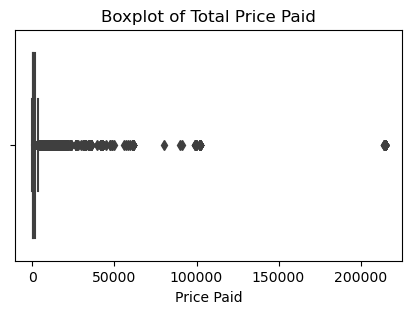

In [20]:
plt.figure(figsize=(5,3))
sns.boxplot(x=df['total_paid'])
plt.title('Boxplot of Total Price Paid')
plt.xlabel('Price Paid')
plt.show()

In [21]:
Q1 = df['total_paid'].quantile(0.25)
Q3 = df['total_paid'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['total_paid'] < lower_bound) | (df['total_paid'] > upper_bound)]
print(outliers['total_paid'].count())
proportion_outliers = outliers['total_paid'].count() / df.shape[0]
print(proportion_outliers)
outliers.sort_values('total_paid', ascending=False).head()

26969
0.09715197625326014


,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary,quantity_per_order,grouped,grouped_unit_prices,grouped_prices
8016,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP0023,59.00,2017-01-03 20:19:59,APP,Apple,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,False,13855401,False,NaN,59.00,214746.64,True,-0.01,0.00,2017,1,2,1,1,50-100,0.00,131.00,"Apple iPad Case Smart Keyboard Pro 12.9 "",Appl...","179.0,25.0,19.99,14.99,72.99,12.99,62.99,59.0,...","189.0,29.0,35.0,25.0,89.0,25.0,70.0,59.0,109.0..."
8009,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP1629,179.00,2017-01-03 20:18:39,APP,Apple,"Apple iPad Case Smart Keyboard Pro 12.9 """,Cover with keyboard shortcuts and Spanish (dir...,189.00,False,12635403,True,179.00,179.00,214746.64,True,-0.01,0.05,2017,1,2,1,1,100-200,10.00,131.00,"Apple iPad Case Smart Keyboard Pro 12.9 "",Appl...","179.0,25.0,19.99,14.99,72.99,12.99,62.99,59.0,...","189.0,29.0,35.0,25.0,89.0,25.0,70.0,59.0,109.0..."
8011,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP0927,19.99,2017-01-03 20:18:56,APP,Apple,EarPods Apple Headphones with Remote and Mic (...,EarPods headphones Apple iPhone iPad and iPod ...,35.00,True,5384,True,19.99,19.99,214746.64,True,-0.01,0.43,2017,1,2,1,1,0-30,15.01,131.00,"Apple iPad Case Smart Keyboard Pro 12.9 "",Appl...","179.0,25.0,19.99,14.99,72.99,12.99,62.99,59.0,...","189.0,29.0,35.0,25.0,89.0,25.0,70.0,59.0,109.0..."
8012,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP0698,14.99,2017-01-03 20:18:59,APP,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,25.00,True,1230,True,14.99,14.99,214746.64,True,-0.01,0.40,2017,1,2,1,1,0-30,10.01,131.00,"Apple iPad Case Smart Keyboard Pro 12.9 "",Appl...","179.0,25.0,19.99,14.99,72.99,12.99,62.99,59.0,...","189.0,29.0,35.0,25.0,89.0,25.0,70.0,59.0,109.0..."
8013,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP0703,72.99,2017-01-03 20:19:04,APP,Apple,"85W MagSafe charger Apple MacBook Pro 15 ""/ 17...",Apple MagSafe Power Charger 85W MacBook Pro un...,89.00,True,13005399,True,72.99,72.99,214746.64,True,-0.01,0.18,2017,1,2,1,1,50-100,16.01,131.00,"Apple iPad Case Smart Keyboard Pro 12.9 "",Appl...","179.0,25.0,19.99,14.99,72.99,12.99,62.99,59.0,...","189.0,29.0,35.0,25.0,89.0,25.0,70.0,59.0,109.0..."


When the unit_price we chose is 5000 euros, then we should include orders above that price, however, we do not need orders of 250 000 Euros. 

In [22]:
df = df.loc[df['total_paid']< 15000].copy()

#### 2.3.3 Difference price paid and the Total price of the order

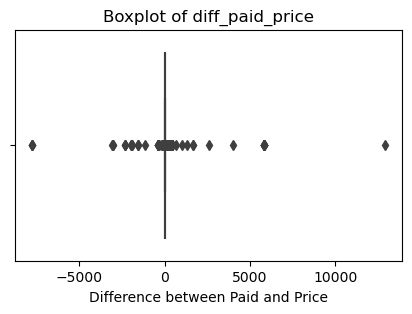

In [23]:
plt.figure(figsize=(5,3))
sns.boxplot(x=df['diff_paid_totalprice'])
plt.title('Boxplot of diff_paid_price')
plt.xlabel('Difference between Paid and Price')
plt.show()

In [24]:
Q1 = df['diff_paid_totalprice'].quantile(0.25)
Q3 = df['diff_paid_totalprice'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['diff_paid_totalprice'] < lower_bound) | (df['diff_paid_totalprice'] > upper_bound)]

print(outliers['diff_paid_totalprice'].count())
proportion_outliers = outliers['diff_paid_totalprice'].count() / df.shape[0]
print(proportion_outliers)
outliers.sort_values('diff_paid_totalprice', ascending=False).tail()

57726
0.20843624073833356


,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary,quantity_per_order,grouped,grouped_unit_prices,grouped_prices
226703,508818,2018-02-09 13:43:30,6.59,Shopping Basket,1.00,PAC2117,3112.59,2018-02-09 13:43:30,PAC,Pack,"Apple iMac 27 ""Core i7 Retina 5K 42GHz | 16GB ...",IMac desktop computer 27 inch Retina 5K RAM 16...,3319.00,False,"5,74E+15",True,3112.59,3112.59,3112.59,True,-3106.00,0.06,2018,6,5,2,1,1500+,206.41,1.00,"Apple iMac 27 ""Core i7 Retina 5K 42GHz | 16GB ...",3112.59,3319.0
184863,519801,2018-03-02 08:59:34,31.22,Shopping Basket,1.00,LAC0154-A,1215.26,2018-03-02 08:59:34,LAC,LaCie,Open - 10TB LaCie 5big Thunderbolt 2,Reconditioned 10TB external hard drive and Thu...,1399.00,False,11935397,True,1215.26,1215.26,7771.23,True,-7740.01,0.13,2018,9,5,3,1,500-1500,183.74,4.00,"Open - 10TB LaCie 5big Thunderbolt 2,20TB LaCi...","1215.26,1689.99,2139.99,2725.99","1399.0,1899.0,2399.0,3099.0"
184865,519801,2018-03-02 08:59:34,31.22,Shopping Basket,1.00,LAC0162,2139.99,2018-03-02 08:59:34,LAC,LaCie,30TB LaCie 5big Thunderbolt 2,30TB external hard drive designed to work 24x7...,2399.00,False,11935397,True,2139.99,2139.99,7771.23,True,-7740.01,0.11,2018,9,5,3,1,1500+,259.01,4.00,"Open - 10TB LaCie 5big Thunderbolt 2,20TB LaCi...","1215.26,1689.99,2139.99,2725.99","1399.0,1899.0,2399.0,3099.0"
184864,519801,2018-03-02 08:59:34,31.22,Shopping Basket,1.00,LAC0161,1689.99,2018-03-02 08:59:34,LAC,LaCie,20TB LaCie 5big Thunderbolt 2,20TB external hard drive designed to work 24x7...,1899.00,False,11935397,True,1689.99,1689.99,7771.23,True,-7740.01,0.11,2018,9,5,3,1,1500+,209.01,4.00,"Open - 10TB LaCie 5big Thunderbolt 2,20TB LaCi...","1215.26,1689.99,2139.99,2725.99","1399.0,1899.0,2399.0,3099.0"
184866,519801,2018-03-02 08:59:34,31.22,Shopping Basket,1.00,LAC0196,2725.99,2018-03-02 08:59:34,LAC,LaCie,40TB LaCie 5big Thunderbolt 2 7200rpm,40TB external hard drive designed to work 24x7...,3099.00,False,11935397,True,2725.99,2725.99,7771.23,True,-7740.01,0.12,2018,9,5,3,1,1500+,373.01,4.00,"Open - 10TB LaCie 5big Thunderbolt 2,20TB LaCi...","1215.26,1689.99,2139.99,2725.99","1399.0,1899.0,2399.0,3099.0"


Let us drop all the remaining outliers here.

In [25]:
df = df.loc[~df['diff_paid_totalprice'].isin(outliers['diff_paid_totalprice'])]

#### 3.2.4 Difference Price and Unit_Price

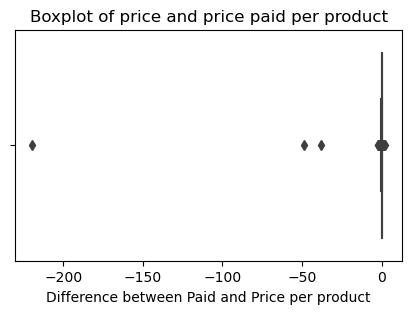

In [26]:
plt.figure(figsize=(5,3))
sns.boxplot(x=df['promo_perc'])
plt.title('Boxplot of price and price paid per product')
plt.xlabel('Difference between Paid and Price per product')
plt.show()

In [27]:
Q1 = df['promo_perc'].quantile(0.25)
Q3 = df['promo_perc'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['promo_perc'] < lower_bound) | (df['promo_perc'] > upper_bound)]

print(outliers['promo_perc'].count())
proportion_outliers = outliers['promo_perc'].count() / df.shape[0]
print(proportion_outliers)
outliers.sort_values('promo_perc', ascending=False).head()

12825
0.05850234009360374


,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary,quantity_per_order,grouped,grouped_unit_prices,grouped_prices
26487,365886,2017-06-15 12:51:18,30.00,Cancelled,1.00,APP1465,-119.00,2017-06-15 12:48:54,APP,Apple,Spanish Keyboard Keyboard Magic Apple Mac (OEM),Spanish Keyboard Mac and Apple iPad Ultrathin ...,119.00,True,13855401,True,-119.00,-119.00,30.00,True,0.00,2.00,2017,24,4,6,2,0-30,238.00,2.00,Spanish Keyboard Keyboard Magic Apple Mac (OEM...,"-119.0,149.0","119.0,149.0"
194254,447669,2017-11-27 11:34:55,0.00,Shopping Basket,1.00,MAT0007,0.00,2017-11-27 11:34:55,MAT,Matias,Matias Bluetooth keyboard Aluminum + Spanish n...,Aluminum Bluetooth keypad manages 4 devices si...,119.99,True,13855401,True,0.00,0.00,0.00,True,0.00,1.00,2017,48,1,11,4,0-30,119.99,1.00,Matias Bluetooth keyboard Aluminum + Spanish n...,0.0,119.99
162911,496819,2018-01-23 12:12:58,139.98,Shopping Basket,1.00,OTT0189,0.00,2018-01-23 12:12:58,OTT,Otterbox,OtterBox iPhone Case X Symmetry Clear Transpar...,glitter transparent cover with a piece for iPh...,34.99,False,11865403,True,0.00,0.00,139.98,True,0.00,1.00,2018,4,2,1,1,0-30,34.99,8.00,Griffin Survivor iPhone Case 7 Clear Smoke / C...,"0.0,0.0,46.66,0.0,0.0,0.0","24.99,32.99,69.99,9.99,34.99,39.99"
174267,480449,2018-01-03 00:22:22,0.00,Shopping Basket,1.00,JBL0096,0.00,2018-01-03 00:22:22,JBL,JBL,GO JBL Bluetooth Portable Speaker Black,Compact Bluetooth Handsfree for iPhone iPad an...,29.99,False,5398,True,0.00,0.00,0.00,True,0.00,1.00,2018,1,3,1,1,0-30,29.99,2.00,"GO JBL Bluetooth Portable Speaker Black,JBL GO...","0.0,0.0","29.99,29.99"
174268,480449,2018-01-03 00:22:22,0.00,Shopping Basket,1.00,JBL0097,0.00,2018-01-03 00:22:22,JBL,JBL,JBL GO Bluetooth Speaker Blue,Compact Bluetooth Handsfree for iPhone iPad an...,29.99,True,5398,True,0.00,0.00,0.00,True,0.00,1.00,2018,1,3,1,1,0-30,29.99,2.00,"GO JBL Bluetooth Portable Speaker Black,JBL GO...","0.0,0.0","29.99,29.99"


Let's drop all promo percentages over 90% since it sounds really unreasonable to give that high of percentages.

In [28]:
df = df.loc[df['promo_perc']<0.9].copy()

Only use this code below, when you want to have a copy of the final merged table downloaded.

Let's see a distributional grpah of the price paid

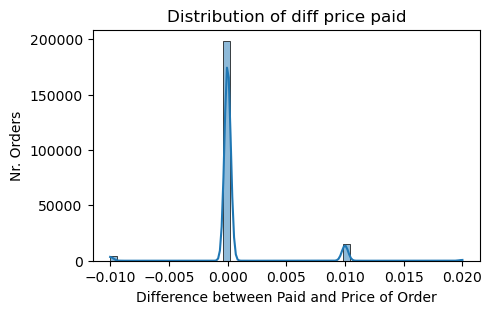

In [29]:
plt.figure(figsize=(5,3))
sns.histplot(df['diff_paid_totalprice'], bins=50, kde=True)
plt.title('Distribution of diff price paid')
plt.xlabel('Difference between Paid and Price of Order')
plt.ylabel('Nr. Orders')
plt.show()

#### 2.3.1 Negative prices

In [30]:
# Convert columns to appropriate numeric data type
# Here, I'm assuming columns 'col1', 'col2', ... are the columns you want to check
# You might need to modify this list based on your actual column names.
numeric_cols = ['total_paid', 'product_quantity', 'unit_price', 'price']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Now, find rows with negative values in those columns
negative_rows = df[df[numeric_cols].lt(0).any(axis=1)]
negative_rows

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary,quantity_per_order,grouped,grouped_unit_prices,grouped_prices


In [31]:
# from IPython.display import FileLink, FileLinks

# df.to_csv('/Users/merlesteffen/Documents/GitHub/Eniac/Data-Eniac/data.csv', index=False)

In [32]:
df1 = df.reset_index(drop=True).copy()

### 2.4 Second Dataframe, with completed orders

Do this as a laast step so all columns and the cleaning/ merging are the same in both dataframes

In [33]:
df_com = df1.loc[df1['state']=='Completed'].reset_index(drop=True).copy()
df_com.head()

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary,quantity_per_order,grouped,grouped_unit_prices,grouped_prices
0,347721,2017-04-20 10:22:00,23.99,Completed,1.00,8MO0007,23.99,2017-04-20 10:20:02,8MO,8Mobility,8Mobility iSlice Micro SD adapter for Macbook ...,Micro SD card adapter for MacBook Air 13-inch,35.00,False,12585395,True,23.99,23.99,23.99,True,0.00,0.31,2017,16,4,4,2,0-30,11.01,1.00,8Mobility iSlice Micro SD adapter for Macbook ...,23.99,35.0
1,347743,2017-04-20 11:28:27,23.99,Completed,1.00,8MO0009,23.99,2017-04-20 11:21:25,8MO,8Mobility,8Mobility iSlice Micro SD Adapter for Macbook ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,True,12585395,True,23.99,23.99,23.99,True,0.00,0.31,2017,16,4,4,2,0-30,11.01,1.00,8Mobility iSlice Micro SD Adapter for Macbook ...,23.99,35.0
2,347761,2017-04-21 08:56:30,66.97,Completed,1.00,8MO0012,23.99,2017-04-20 11:56:42,8MO,8Mobility,8Mobility iSlice Micro SD Adapter MacBook Pro ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,False,12585395,True,23.99,23.99,66.97,True,0.00,0.31,2017,16,5,4,2,0-30,11.01,3.00,8Mobility iSlice Micro SD Adapter MacBook Pro ...,"23.99,12.99,29.99","35.0,12.99,49.99"
3,347761,2017-04-21 08:56:30,66.97,Completed,1.00,SAN0140,12.99,2017-04-20 11:56:34,SAN,SanDisk,SanDisk Ultra 32GB microSDHC Memory Card + SD ...,Adapter and microSDHC memory card 32 GB Class ...,12.99,False,57445397,False,NaN,12.99,66.97,True,0.00,0.00,2017,16,5,4,2,0-30,0.00,3.00,8Mobility iSlice Micro SD Adapter MacBook Pro ...,"23.99,12.99,29.99","35.0,12.99,49.99"
4,347761,2017-04-21 08:56:30,66.97,Completed,1.00,SAN0099,29.99,2017-04-21 08:54:44,SAN,SanDisk,SanDisk Connect Wireless Flash Drive 64GB Wire...,Wireless 64GB storage for iPhone / iPad / Mac.,49.99,True,42945397,True,29.99,29.99,66.97,True,0.00,0.40,2017,16,5,4,2,0-30,20.00,3.00,8Mobility iSlice Micro SD Adapter MacBook Pro ...,"23.99,12.99,29.99","35.0,12.99,49.99"


## 3. Analysis

Univariate Analysis

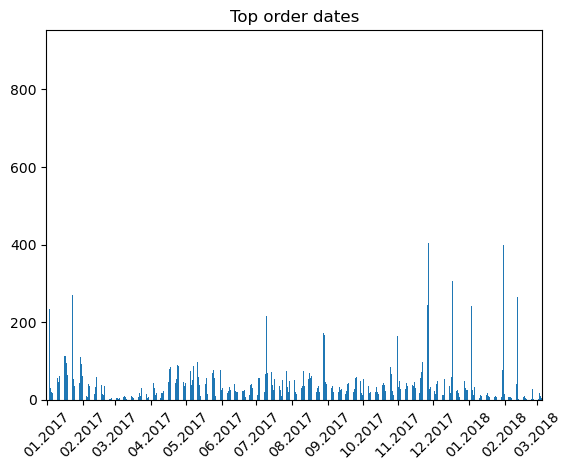

In [34]:
# Plotting the data
ax = df_com['created_date'].dt.date.value_counts().sort_index().plot(kind='bar', title='Top order dates')

# Extract the first date of each unique month-year combination
first_dates_of_each_month = df_com.drop_duplicates(subset='created_date', keep='first').sort_values('created_date')['created_date'].dt.to_period('M').drop_duplicates().dt.to_timestamp()

# Find the positions of these first dates in the sorted index of the dates from df1
positions = [sorted(df1['created_date'].dt.date.unique()).index(date.date()) for date in first_dates_of_each_month]

# Get the month-year labels for these dates
labels = first_dates_of_each_month.dt.strftime('%m.%Y')

# Set the tick positions and labels
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45)
plt.show()

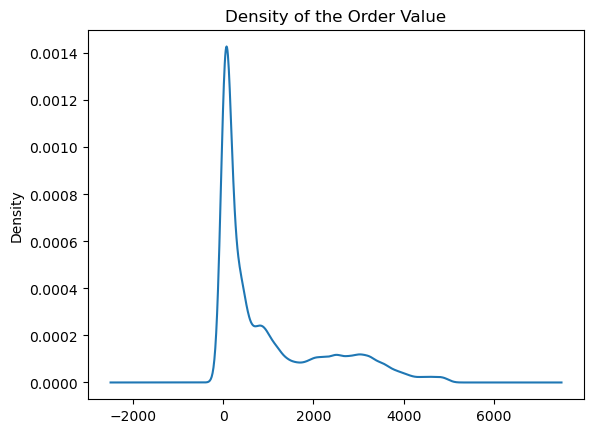

In [35]:
filtered_order_prices = df1[df1['order_price'] < 5000]['order_price']
filtered_order_prices.plot(kind='kde', title='Density of the Order Value');

In [36]:
df1['unit_price'].sort_values()

141269      1.99
141250      1.99
141297      1.99
142523      1.99
141380      1.99
           ...  
108150   9656.00
100235   9663.23
176031   9841.99
176188   9841.99
176161   9841.99
Name: unit_price, Length: 218511, dtype: float64

In [37]:
df1.loc[df1['unit_price']<0]

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary,quantity_per_order,grouped,grouped_unit_prices,grouped_prices


In [38]:
df1.dtypes

order_id                        object
created_date            datetime64[ns]
total_paid                     float64
state                         category
product_quantity               float64
sku                             object
unit_price                     float64
date                    datetime64[ns]
short                           object
long                            object
name                            object
desc                            object
price                          float64
in_stock                          bool
type                          category
price_promotion                   bool
promo_price                    float64
unit_price_total               float64
order_price                    float64
order_inc_promo                   bool
diff_paid_totalprice           float64
promo_perc                     float64
year                            UInt32
week                            UInt32
day                             UInt32
month                    

### 3.1 Analyzing Order Patterns in Relation to Discounts

Objective:
To understand if the introduction or availability of discounts affects order patterns – both in terms of quantity and frequency.

#### 3.1.1 Understand basic metrics

In [39]:
total_orders = df1['order_id'].nunique()
avg_order_value = df1.groupby('order_id')['total_paid'].first().mean()

avg_items_per_order = df1.groupby('order_id').size().mean()
print(f'The total orders are: {total_orders}, the average order values is: {avg_order_value}, and the average items per order are: {avg_items_per_order}')


The total orders are: 149348, the average order values is: 718.6305701448964, and the average items per order are: 1.463099606288668


Let me check if all total_paid values are the same within each order

In [40]:
unique_paid_counts = df1.groupby('order_id')['total_paid'].nunique()
inconsistent_orders = unique_paid_counts[unique_paid_counts > 1]
if not inconsistent_orders.empty:
    print("There are orders with inconsistent 'total_paid' values:")
    print(inconsistent_orders)
else:
    print("All orders have consistent 'total_paid' values. Therefore I can use the .first() method.")

All orders have consistent 'total_paid' values. Therefore I can use the .first() method.


#### 3.1.2 Compare Metrics

In [41]:
avg_order_value_discounted =(
    df1[df1['order_inc_promo'] == True]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)
avg_order_value_non_discounted =(
    df1[df1['order_inc_promo'] == False]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)

In [42]:
avg_items_discounted =(
    df1[df1['order_inc_promo'] == True]
    .groupby('order_id')['product_quantity']
    .sum()
    .mean()
    .round(2)
)
avg_items_non_discounted =(
    df1[df1['order_inc_promo'] == False]
    .groupby('order_id')['product_quantity']
    .sum()
    .mean()
    .round(2)
)

In [43]:
print(f'The average order value of discounted orders is: {avg_order_value_discounted}, compared to the average value of non discounted orders: {avg_order_value_non_discounted}\
. Moreover, the average number of items in an order with prmotion is: {avg_items_discounted}, while it is : {avg_items_non_discounted} for non discounted orders.')

The average order value of discounted orders is: 1758.16, compared to the average value of non discounted orders: 413.06. Moreover, the average number of items in an order with prmotion is: 1.63, while it is : 1.18 for non discounted orders.


Let us only look at completed orders for now.

In [44]:
df_compl = df.loc[df['state']=='Completed']
avg_order_value_discounted_c =(
    df_compl[df_compl['order_inc_promo'] == True]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)
avg_order_value_non_discounted_c =(
    df_compl[df_compl['order_inc_promo'] == False]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)
avg_items_discounted_c =(
    df_compl[df_compl['order_inc_promo'] == True]
    .groupby('order_id')['product_quantity']
    .sum()
    .mean()
    .round(2)
)
avg_items_non_discounted_c =(
    df_compl[df_compl['order_inc_promo'] == False]
    .groupby('order_id')['product_quantity']
    .sum()
    .mean()
    .round(2)
)

In [45]:
print(f'For completed orders the summary looks like: The average order value of discounted orders is: {avg_order_value_discounted_c}, compared to the average value of non discounted orders: {avg_order_value_non_discounted_c}\
. Moreover, the average number of items in an order with prmotion is: {avg_items_discounted_c}, while it is : {avg_items_non_discounted_c} for non discounted orders.')

For completed orders the summary looks like: The average order value of discounted orders is: 1075.12, compared to the average value of non discounted orders: 597.22. Moreover, the average number of items in an order with prmotion is: 1.63, while it is : 1.29 for non discounted orders.


### 3.2 Temporal Analysis

In [46]:
df1['created_month'] = df1['created_date'].dt.month # this is an integer, maybe change later
monthly_discounted_orders = df1[df1['price_promotion']].groupby('created_month').size()
monthly_discounted_orders

created_month
1     41341
2     23431
3     15542
4      7874
5      7960
6      6931
7     10484
8      8095
9      8700
10    10501
11    31555
12    25201
dtype: int64

For now only use completed orders, since otherwise we cannot infer about the promotion.

In [47]:
df_compl['created_month'] = df_compl['created_date'].dt.month # this is an integer, maybe change later
monthly_discounted_orders_c = df_compl[df_compl['price_promotion']].groupby('created_month').size()

/var/folders/7h/lk9jxn256x10l_m01pz7khdw0000gn/T/ipykernel_59020/2869572320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compl['created_month'] = df_compl['created_date'].dt.month # this is an integer, maybe change later


### 3.3 Visual Analysis

In [48]:
# For all observations
order_count_discounted = df1[df1['price_promotion'] == True]['order_id'].nunique()
order_count_non_discounted = df1[df1['price_promotion'] == False]['order_id'].nunique()

# For completed observations
order_count_discounted_c = df_compl[df_compl['price_promotion'] == True]['order_id'].nunique()
order_count_non_discounted_c = df_compl[df_compl['price_promotion'] == False]['order_id'].nunique()

order_counts = [order_count_discounted, order_count_non_discounted]
order_counts_c = [order_count_discounted_c, order_count_non_discounted_c]

In [49]:
# Calculate total revenues
total_rev_dis_d = (df1.loc[df1['price_promotion'] == True]['unit_price_total'].sum())/1000000
total_rev_non_dis = (df1.loc[df1['price_promotion'] == False]['unit_price_total'].sum())/1000000
total_revenues = [total_rev_dis_d, total_rev_non_dis]

total_rev_dis_d_c = (df_compl.loc[df_compl['price_promotion'] == True]['unit_price_total'].sum())/1000000
total_rev_non_dis_c = (df_compl.loc[df_compl['price_promotion'] == False]['unit_price_total'].sum())/1000000
total_revenues_c = [total_rev_dis_d_c, total_rev_non_dis_c]

In [50]:
total_revenues

[101.39384301000003, 5.93191938]

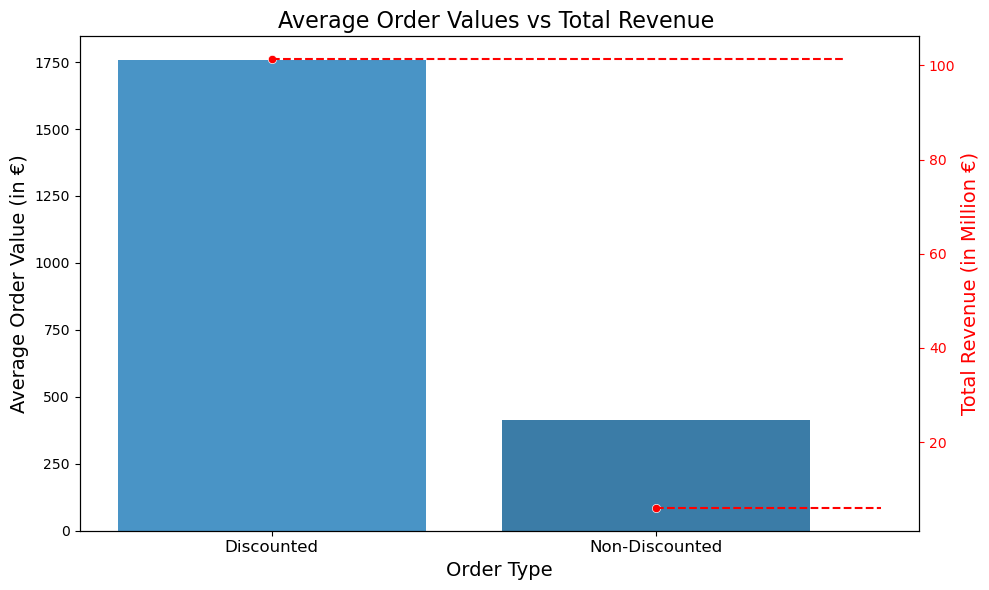

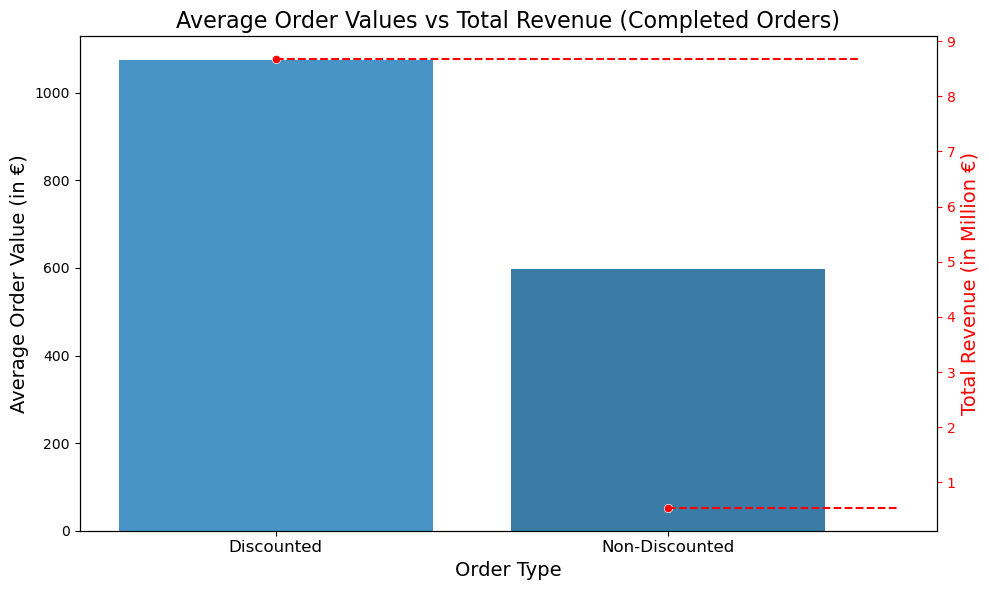

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palettes
palette_1 = ["#3498db", "#2980b9"]

def plot_order_values_vs_revenue(order_values, total_revenues, title_suffix=''):
    # Create the figure and the first axis
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot bars on the first y-axis
    sns.barplot(x=['Discounted', 'Non-Discounted'], y=order_values, ax=ax1, palette=palette_1)

    # Create a secondary y-axis and plot the scatter points
    ax2 = ax1.twinx()
    sns.scatterplot(x=['Discounted', 'Non-Discounted'], y=total_revenues, ax=ax2, color='red')
    
    # Drawing lines to the right from each scatter point
    for idx, revenue in enumerate(total_revenues):
        line_x_start = idx  # start from the scatter dot's x-position
        line_x_end = ax2.get_xlim()[-1]  # end at the right-most position
        ax2.plot([line_x_start, line_x_end], [revenue, revenue], color='red', linestyle="--")
    

    # Set labels and titles
    ax1.set_ylabel('Average Order Value (in €)', fontsize=14)
    ax2.set_ylabel('Total Revenue (in Million €)', color='red', fontsize=14)
    ax1.set_title(f'Average Order Values vs Total Revenue {title_suffix}', fontsize=16)
    ax1.set_xlabel('Order Type', fontsize=14)
    ax1.set_xticks(range(len(order_values)))
    ax1.set_xticklabels(['Discounted', 'Non-Discounted'], fontsize=12)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    
    ax2.tick_params(axis='y', colors='red')

    plt.tight_layout()
    plt.show()

# Plot for all observations
plot_order_values_vs_revenue([avg_order_value_discounted, avg_order_value_non_discounted], total_revenues)

# Plot for completed observations (_c version)
plot_order_values_vs_revenue([avg_order_value_discounted_c, avg_order_value_non_discounted_c], total_revenues_c, title_suffix='(Completed Orders)')

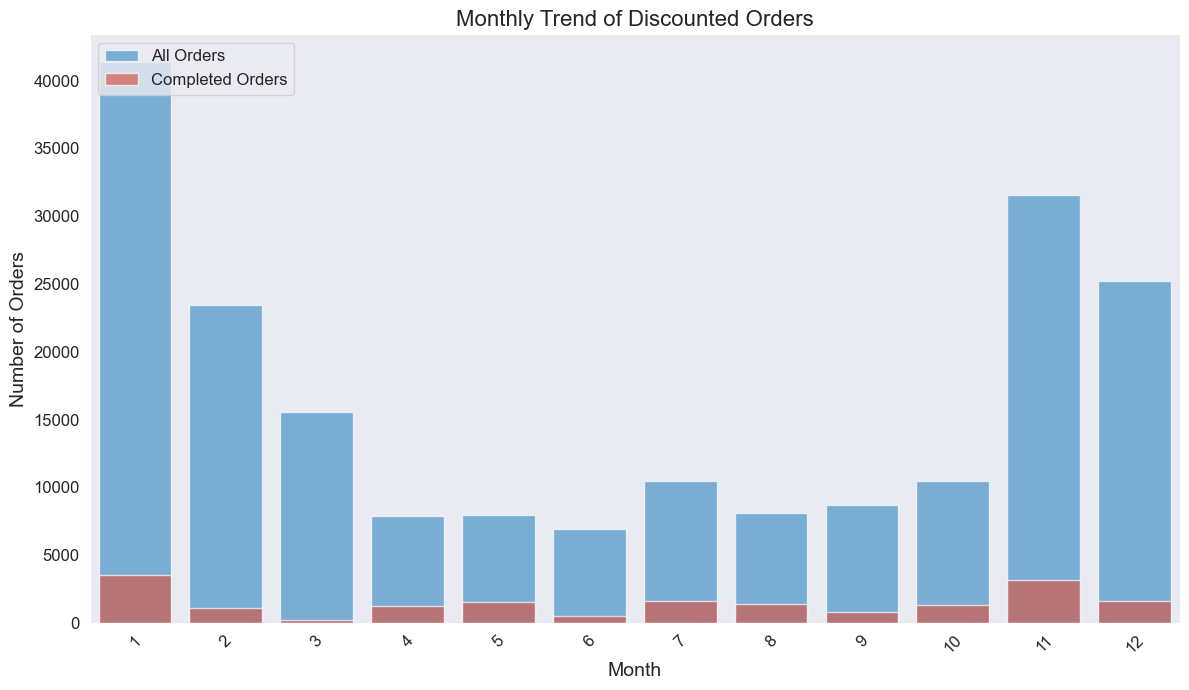

In [52]:
sns.set_style("dark")

# Define color palettes
palette_1 = ["#3498db", "#e74c3c"]
palette_2 = ["#2980b9", "#c0392b"]

plt.figure(figsize=(12, 7))

# Plot total orders first
sns.barplot(x=monthly_discounted_orders.index, 
            y=monthly_discounted_orders.values,
            color=palette_1[0], 
            label="All Orders",
            alpha=0.7)  # Alpha controls the transparency

# Plot completed orders on top
sns.barplot(x=monthly_discounted_orders_c.index, 
            y=monthly_discounted_orders_c.values,
            color=palette_1[1], 
            label="Completed Orders",
            alpha=0.7)

plt.title('Monthly Trend of Discounted Orders', fontsize=16)
plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)  # Display the legend
plt.tight_layout()
plt.show()


Possible Conclusions:

- If orders with discounts have a significantly higher average value or quantity, it suggests discounts might be driving larger orders.
- If there's a temporal trend showing increased discount orders during specific times, it might suggest seasonal trends or the effects of periodic discount campaigns.

### 3.4 Analyzing Customer Behavior and Retention with Respect to Discounts:

#### 3.4.1 Retention Rate with Respect to Discounts:

To understand if customers acquired during promotional periods are more likely to come back.

In [53]:
grouped = (
    df1
    .loc[df1['state'] == 'Completed']
    .groupby(['week', 'month', 'quarter', 'year'])
    ['promo_perc']
    .mean()
    .reset_index()
)

grouped

,week,month,quarter,year,promo_perc
0,1,1,1,2017,0.16
1,1,1,1,2018,0.16
2,2,1,1,2017,0.18
3,2,1,1,2018,0.15
4,3,1,1,2017,0.22
...,...,...,...,...,...
71,49,12,4,2017,0.09
72,50,12,4,2017,0.10
73,51,12,4,2017,0.15
74,52,1,1,2016,0.18


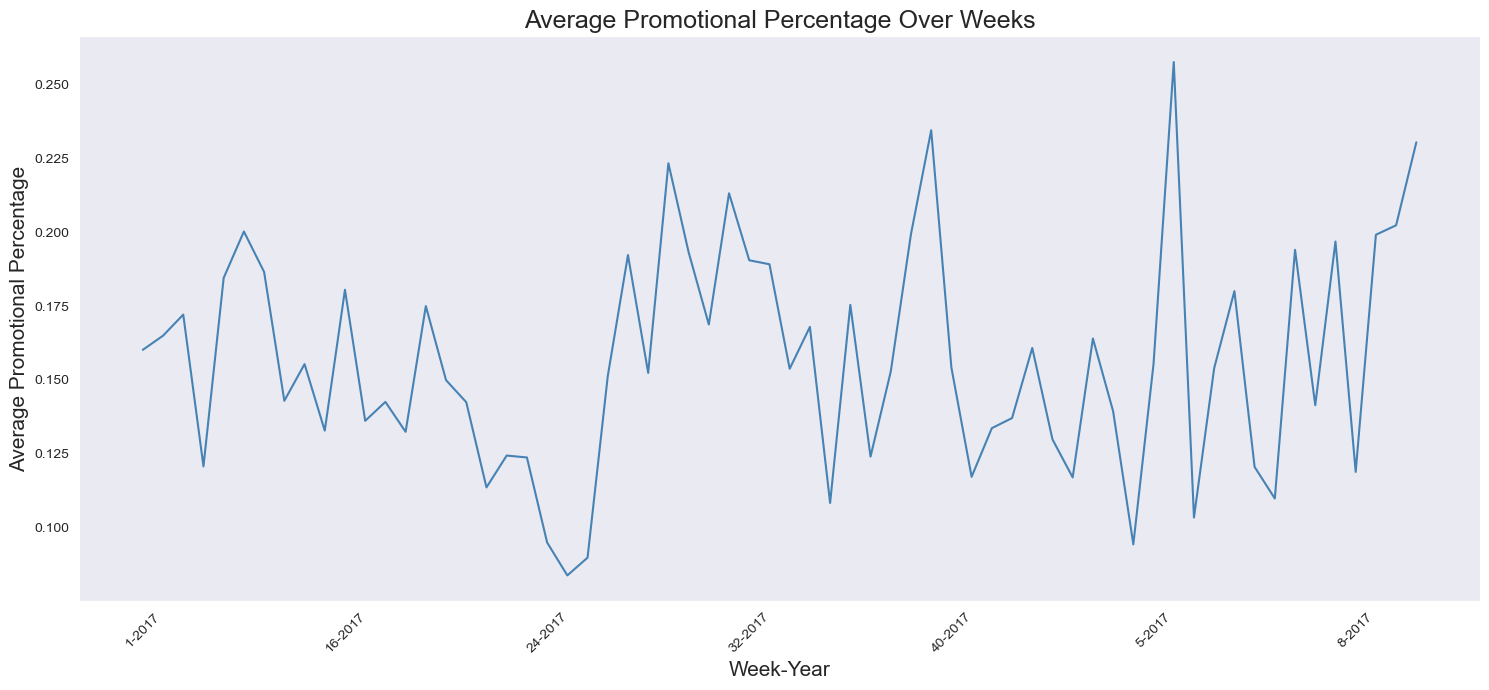

In [54]:
import matplotlib.pyplot as plt

# Creating 'week-year' for plotting
grouped['week-year'] = grouped['week'].astype(str) + '-' + grouped['year'].astype(str)

# Group by 'week-year' and calculate the mean of 'promo_perc'
weekly_promo = grouped.groupby('week-year')['promo_perc'].mean()

# Plot
plt.figure(figsize=(15, 7))
weekly_promo.plot(color='steelblue')
plt.title('Average Promotional Percentage Over Weeks', fontsize=18)
plt.xlabel('Week-Year', fontsize=15)
plt.ylabel('Average Promotional Percentage', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [55]:
 grouped =(
     df1
     .loc[df1['state']=='Completed']
     .groupby([df1['created_date'].dt.isocalendar().week, df1['created_date'].dt.month, df1['created_date'].dt.quarter, df1['created_date'].dt.isocalendar().year])
     ['promo_perc']
     .mean()
 )
#grouped.columns = ['week', 'month', 'quarter', 'promo_perc']
grouped.columns = ['week', 'month', 'quarter', 'promo_perc']
print(grouped)

week  created_date  created_date  year
1     1             1             2017   0.16
                                  2018   0.16
2     1             1             2017   0.18
                                  2018   0.15
3     1             1             2017   0.22
                                         ... 
49    12            4             2017   0.09
50    12            4             2017   0.10
51    12            4             2017   0.15
52    1             1             2016   0.18
      12            4             2017   0.12
Name: promo_perc, Length: 76, dtype: float64


Make the Line Plot

look for weeks/months/days where promotion in percentage/ price high. Which one to use?

## 4. Feature Analysis

- Scatterplot
- Heatmap Correlation
- Pairplot
- Groupby comparison

Make a column, boolean with completed = True and the rest False (state)

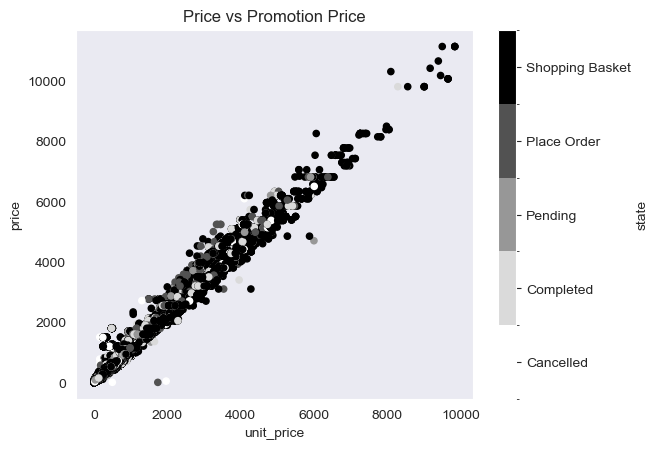

In [56]:
df1.plot(kind='scatter', x='unit_price', y='price', c='state', title='Price vs Promotion Price');

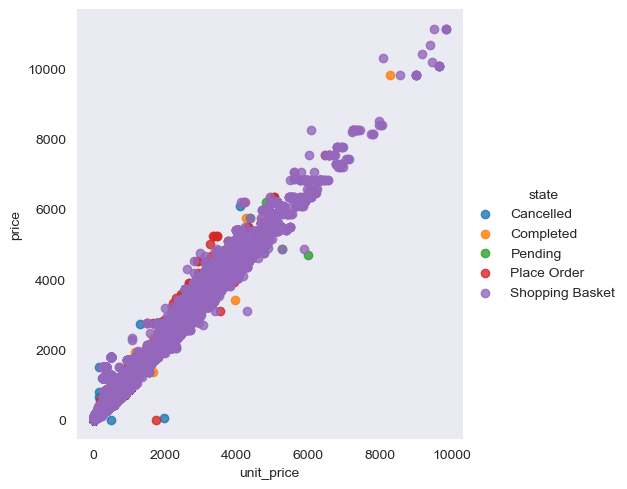

In [57]:
sns.lmplot(x='unit_price', y='price', data=df1, hue='state', fit_reg=False);

In [58]:
df1['unit_price'].max()

9841.99

### 4.1 Items in basket

1. Products bought together (were one/ more discounted) other orders with just one of those items
2. Unit_price of items in basket – unit_price of those items bought (do customers wait for promotion?)

2. Unit_price of items in basket – unit_price of those items bought (do customers wait for promotion?)

In [59]:
df1.loc[df1['state']=='Shopping Basket']['order_id'].nunique()

102441

In [60]:
df1.loc[df1['state']=='Shopping Basket']['product_quantity'].sum()

170296.0

There are 102 687 Orders, with 173 610 products in shopping baskets. Why do people not check out and how could we help people order quicker?

In [61]:
df_sh = df1.loc[df1['state']=='Shopping Basket'].reset_index(drop=True).copy()
# df_com already defined

In [62]:
sh_b_mean = (df_sh['unit_price_total'].sum())/ (df_sh['product_quantity'].sum())
sh_b_mean.round(2)

452.27

In [63]:
df_com_mean = (df_com['unit_price_total'].sum())/ (df_com['product_quantity'].sum())
df_com_mean.round(2)

406.32

In [64]:
df_b_disc_mean = (df_sh['promo_in_monetary'].sum())/ (df_sh['product_quantity'].sum())
df_com_disc_mean = (df_com['promo_in_monetary'].sum())/ (df_com['product_quantity'].sum())
print(f'The mean discount per item of items in the shopping basket is {df_b_disc_mean.round(2)}, while it is {df_com_disc_mean.round(2)} for items in completed orders.')

The mean discount per item of items in the shopping basket is 53.37, while it is 52.71 for items in completed orders.


In [65]:
df_sh_promo_perc = df_sh['promo_perc'].sum()/df_sh['sku'].count()
df_com_promo_perc = df_com['promo_perc'].sum()/df_com['sku'].count()
print(f'The mean discount per item of items in the shopping basket is {df_sh_promo_perc.round(2)}, while it is {df_com_promo_perc.round(2)} \
for items in completed orders.')

The mean discount per item of items in the shopping basket is 0.16, while it is 0.16 for items in completed orders.


In [66]:
df_sh['promo_perc'].describe()

count   157985.00
mean         0.16
std          0.15
min         -2.12
25%          0.06
50%          0.13
75%          0.23
max          0.90
Name: promo_perc, dtype: float64

In [67]:
df_com['promo_perc'].describe()

count   19761.00
mean        0.16
std         0.15
min        -0.47
25%         0.06
50%         0.13
75%         0.22
max         0.89
Name: promo_perc, dtype: float64

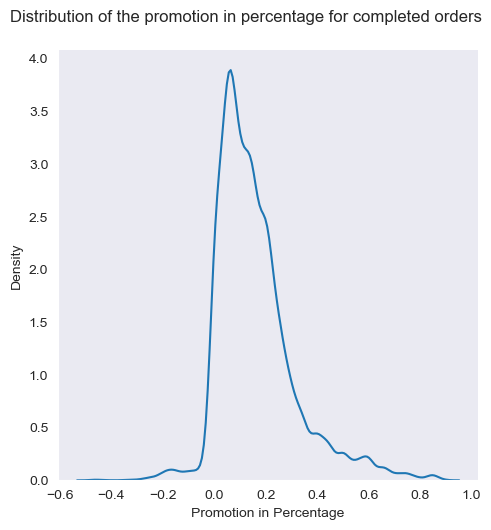

In [68]:
# Your displot code
ax = sns.displot(
    kind="kde",
    data=df_com,
    x="promo_perc"
)

# Set title
ax.fig.suptitle('Distribution of the promotion in percentage for completed orders', y=1.05)

# Rename x-axis
ax.set_axis_labels(x_var='Promotion in Percentage')

plt.show()


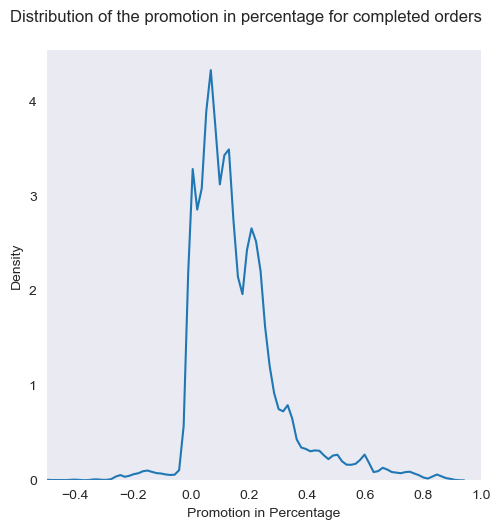

In [69]:
# Your displot code
ax = sns.displot(
    kind="kde",
    data=df_sh,
    x="promo_perc"
)

# Set title
ax.fig.suptitle('Distribution of the promotion in percentage for completed orders', y=1.05)

# Rename x-axis
ax.set_axis_labels(x_var='Promotion in Percentage')
ax.set(xlim=(-0.5, 1.0))

plt.show()


What are other things to look at?
- products bought together? their unit price. Products in basket.

### 4.2 Products Bought together

Let's look at the top 10 orders of two products first

In [70]:
df_compl = df.loc[df['state']=='Completed']
df_sh =df.loc[df['state']=='Shopping Basket']

In [71]:
df_compl.loc[df_compl['name']=='Apple iPhone 6 32GB Space Gray']['order_id'].count()

204

In [72]:
top_5_products_c = df_compl.groupby('name')['order_id'].nunique().sort_values().tail(5)
top_5_products_sh  = df_sh.groupby('name')['order_id'].nunique().sort_values().tail(5)

In [73]:
top_5_products_c 

name
Red 4TB WD 35 "Mac PC hard drive and NAS        142
Apple iPhone 32GB Space Gray                    154
LG 27UD88-W Monitor 27 "UHD 4K USB 3.0 USB-C    177
Apple iPhone 6 32GB Space Gray                  204
IPhone AppleCare Protection Plan                273
Name: order_id, dtype: int64

In [74]:
top_5_products_sh

name
IPhone AppleCare Protection Plan                      2711
AppleCare Protection Plan MacBook / Air / Pro 13 "    3625
IMac AppleCare Protection Plan                        5117
Apple Magic Trackpad 2                                5429
Office 365 Personal 1 license 1 M ± or                6206
Name: order_id, dtype: int64

Users bought the: IPhone AppleCare Protection Plan most and it is also number 5 in the shopping basket items.

In [75]:
# Work with df_compl and df_sh, where the name is = IPhone AppleCare Protection Plan
df_sh = df_sh.loc[df_sh['name']=='IPhone AppleCare Protection Plan']
df_compl = df_compl.loc[df_compl['name']=='IPhone AppleCare Protection Plan']

In [76]:
# Set and Id for all orders, which contain the Iphone Apple Care thingie
import pandas as pd
import numpy as np
df_sh = df_sh.copy()
df_compl = df_compl.copy()

# Define a function to determine the id value based on the product presence
def assign_id(grouped_str):
    if 'IPhone AppleCare Protection Plan' in grouped_str:
        return 1
    else:
        return np.nan  # Return NaN or other desired default value

# Apply the function to the 'grouped' column of df_sh and assign the results to a new 'id' column
df_sh['id'] = df_sh['grouped'].apply(assign_id)

# Repeat for df_compl
df_compl['id'] = df_compl['grouped'].apply(assign_id)

In [77]:
# only include orders, that have id == 1
df_sh = df_sh.loc[pd.notna(df_sh['id'])].copy()
df_compl = df_compl.loc[pd.notna(df_compl['id'])].copy()

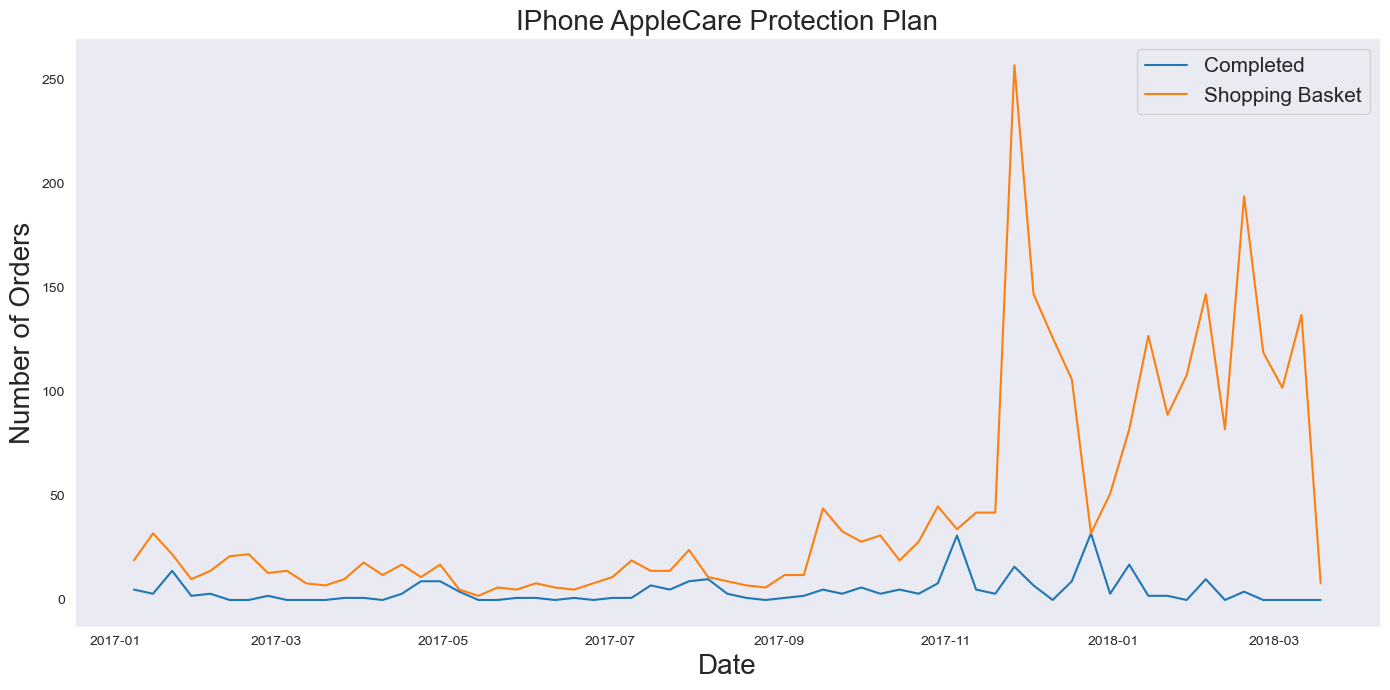

In [78]:
# Make the graph to show correlation between shopping basket and completed orders
# Convert 'created_date' to datetime
df_sh['created_date'] = pd.to_datetime(df_sh['created_date'])
df_compl['created_date'] = pd.to_datetime(df_compl['created_date'])


weekly_counts_sh = (df_sh.groupby([pd.Grouper(key='created_date', freq='W'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Shopping Basket Count'))

weekly_counts_cc = (df_compl.groupby([pd.Grouper(key='created_date', freq='W'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Completed Count'))

# Merge dataframes
weekly_counts = pd.merge(weekly_counts_sh, weekly_counts_cc, on='created_date', how='outer').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='created_date', y='Completed Count', data=weekly_counts, label='Completed')
sns.lineplot(x='created_date', y='Shopping Basket Count', data=weekly_counts, label='Shopping Basket')
plt.title('IPhone AppleCare Protection Plan', fontsize=20) # change this to the product names
plt.ylabel('Number of Orders', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.legend(prop={'size': 15})
plt.tight_layout()
plt.show()

# Let me use this for now. I want to add a line with the promotion price here, theaverage for those orders. 
# 

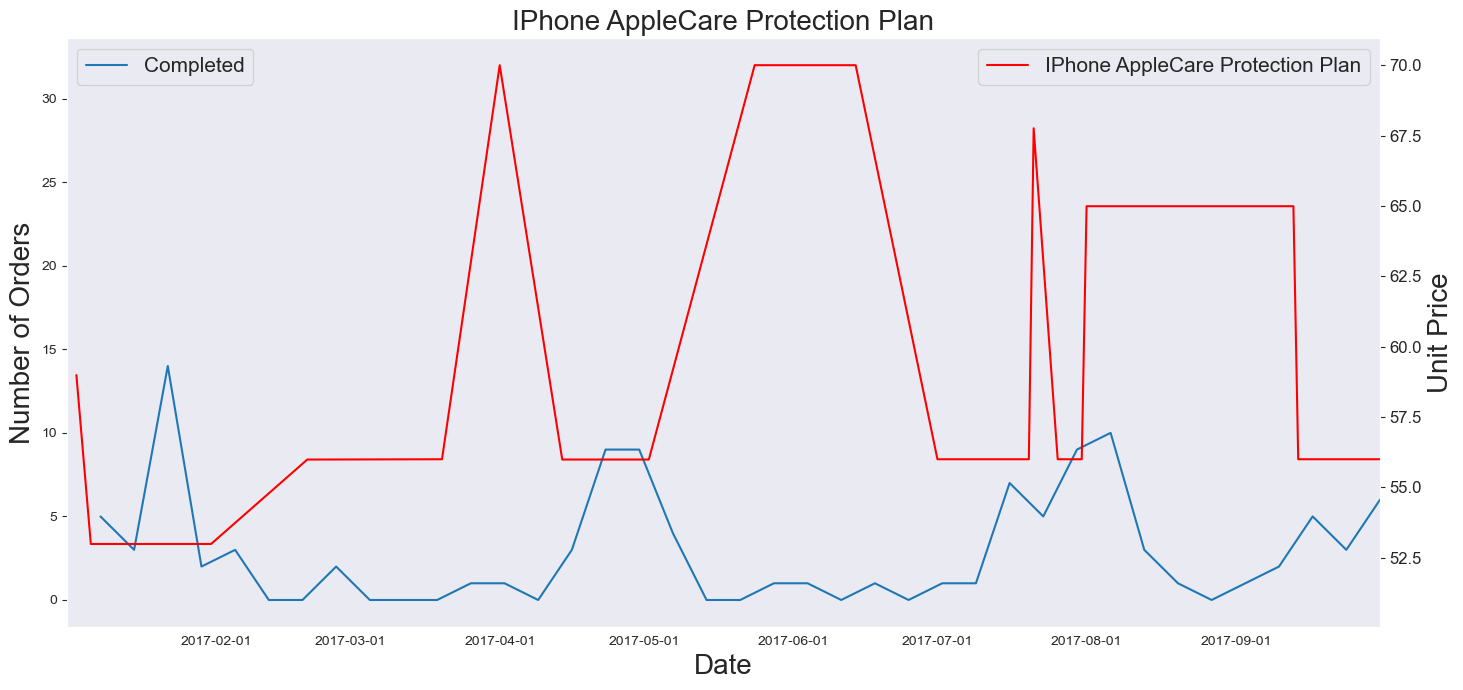

In [79]:


# get average prices
avg_prices_new = df_compl.groupby([pd.Grouper(key='created_date', freq='D'), 'name'])['unit_price'].mean()
# Filter for avg_prices_new using the multi-index
avg_prices_pr1 = avg_prices_new.loc[(slice(None), 'IPhone AppleCare Protection Plan'), ].reset_index(level=1, drop=True)



weekly_counts_sh = (df_sh.groupby([pd.Grouper(key='created_date', freq='W'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Shopping Basket Count'))

weekly_counts_cc = (df_compl.groupby([pd.Grouper(key='created_date', freq='W'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Completed Count'))

# Merge dataframes
weekly_counts = pd.merge(weekly_counts_sh, weekly_counts_cc, on='created_date', how='outer').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='created_date', y='Completed Count', data=weekly_counts, label='Completed')
#sns.lineplot(x='created_date', y='Shopping Basket Count', data=weekly_counts, label='Shopping Basket')
plt.title('IPhone AppleCare Protection Plan', fontsize=20) # change this to the product names
plt.ylabel('Number of Orders', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.legend(prop={'size': 15}, loc='upper left')
plt.tight_layout()

plt.xlim(pd.Timestamp('2017-01'), pd.Timestamp('2017-10'))
# Let me use this for now. I want to add a line with the promotion price here, theaverage for those orders. 



# Create a twin y-axis
ax2 = plt.gca().twinx()

sns.lineplot(x=avg_prices_pr1.index, y=avg_prices_pr1.values, label='IPhone AppleCare Protection Plan', ax=ax2, color='r')

# Add ylabel for the secondary y-axis
ax2.set_ylabel('Unit Price', fontsize=20)

# Add legend for the secondary y-axis
ax2.legend(loc='upper right',prop={'size': 15})
ax2.tick_params(labelsize=12)
#ax2.set_ylim([65, 120])

# ----- Insert the new code snippet here -----
# Get the current x-axis ticks
ax = plt.gca()
ticks = ax.get_xticks()

# If there are any ticks, remove the last one
if len(ticks) > 0:
    ax.set_xticks(ticks[1:-1])


plt.show()

### 4.3 Statistical Model about Promotion

In [80]:
df1.head(1)

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary,quantity_per_order,grouped,grouped_unit_prices,grouped_prices,created_month
0,343034,2017-04-04 10:47:28,23.99,Shopping Basket,1.00,8MO0008,23.99,2017-04-04 10:47:28,8MO,8Mobility,8Mobility iSlice Micro SD Adapter Macbook Pro ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,False,12585395,True,23.99,23.99,23.99,True,0.00,0.31,2017,14,2,4,2,0-30,11.01,1.00,8Mobility iSlice Micro SD Adapter Macbook Pro ...,23.99,35.0,4


price_category, state (y), promo_perc (x)

state = beta + beta1*promo_perc + alphyistatei +error

In [81]:
# Make new dataframe
df1_new = df1.loc[(df1['state']=='Completed')|(df1['state']=='Shopping Basket')].copy()

In [82]:
df1_new = df1_new[['state', 'promo_perc', 'price_category', 'unit_price', 'price','name']]

In [83]:
df1_new['bought'] = 0
df1_new.loc[df1_new['state'] == 'Completed', 'bought'] = 1

In [84]:
import statsmodels.api as sm

df1_new['price_category'] = df1_new['price_category'].astype(str)

# Generate dummy variables
dummies = pd.get_dummies(df1_new['price_category'], drop_first=True, prefix='D')

# Reset the index before concatenation
df1_new = df1_new.reset_index(drop=True)
dummies = dummies.reset_index(drop=True)

# Join the dummy DataFrame to the original DataFrame
df1_new = pd.concat([df1_new, dummies], axis=1)

categories = ['0-30', '30-50', '50-100', '100-200', '200-500', '500-1500', '1500+']  

for cat in categories[1:]:  # exclude the first category
    df1_new[f'Interaction_{cat}'] = df1_new['promo_perc'] * df1_new[f'D_{cat}']

# Extracting all necessary columns for the model
X_cols = ['promo_perc'] + [f'D_{cat}' for cat in categories[1:]] + [f'Interaction_{cat}' for cat in categories[1:]]
X = df1_new[X_cols]
X = sm.add_constant(X)
y = df1_new['bought']
model = sm.Logit(y, X).fit()

# Display results
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.342286
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 bought   No. Observations:               177746
Model:                          Logit   Df Residuals:                   177732
Method:                           MLE   Df Model:                           13
Date:                Thu, 24 Aug 2023   Pseudo R-squ.:                 0.01914
Time:                        11:28:05   Log-Likelihood:                -60840.
converged:                       True   LL-Null:                       -62027.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.3748      0.033    -72.273      0.000      -2.439      -2.310

### 4.5 Visual Analysis of Basket and Completed Orders

In [85]:
top_products_c = (df_compl[df_compl['quantity_per_order'] == 1]
                .groupby('name')
                .agg(product_count=('name', 'size'), 
                     avg_unit_price=('unit_price', 'mean'),
                     avg_price=('price', 'mean'))  # Add this line for average price
                .sort_values(by='product_count', ascending=False)
                .head(10))
top_products_c

,product_count,avg_unit_price,avg_price
name,,,
IPhone AppleCare Protection Plan,129,55.89,70.00


In [86]:
top_products_s = (df_sh[df_sh['quantity_per_order'] == 1]
                .groupby('name')
                .agg(product_count=('name', 'size'), 
                     avg_unit_price=('unit_price', 'mean'),
                     avg_price=('price', 'mean'))  # Add this line for average price
                .sort_values(by='product_count', ascending=False)
                .head(10))

top_products_s

,product_count,avg_unit_price,avg_price
name,,,
IPhone AppleCare Protection Plan,871,56.31,70.00


In [87]:
from collections import Counter
from itertools import combinations
import pandas as pd

count = Counter()

# Iterate over rows in df_compl
for idx, row in df_compl.iterrows():
    row_list = row['grouped'].split(',')
    
    product_combos = list(combinations(row_list, 2))
    for combo in product_combos:
        count[combo] += 1

# Create a new DataFrame from the gathered data
data = []
for item, freq in count.most_common(5):
    data.append([item, freq])

result_df = pd.DataFrame(data, columns=['name', 'frequency'])
result_df['id_c'] = range(1, len(result_df) + 1)
result_df

,name,frequency,id_c
0,"(Apple iPhone 64GB Space Gray 8, IPhone AppleC...",13,1
1,"(IPhone AppleCare Protection Plan, Griffin Sur...",8,2
2,"(Apple iPhone 8 Plus 256GB Space Gray, IPhone ...",7,3
3,"(Apple iPhone 6 32GB Space Gray, IPhone AppleC...",7,4
4,"(Apple iPhone 64GB Space Gray X, IPhone AppleC...",6,5


In [88]:
from collections import Counter
from itertools import combinations
import pandas as pd

count = Counter()

# Use df_sh instead of df
for idx, row in df_sh.iterrows():
    row_list = row['grouped'].split(',')
    
    product_combos = list(combinations(row_list, 2))
    for combo in product_combos:
        count[combo] += 1

# Create a new DataFrame from the gathered data
data = []
for item, freq in count.most_common(5):
    data.append([item, freq])

result_df_sh = pd.DataFrame(data, columns=['name', 'frequency'])
result_df_sh['id_sh'] = range(1, len(result_df_sh) + 1)
result_df_sh

,name,frequency,id_sh
0,"(IPhone AppleCare Protection Plan, Belkin iPho...",446,1
1,"(IPhone AppleCare Protection Plan, Wireless He...",416,2
2,"(IPhone AppleCare Protection Plan, Zagg Invisi...",258,3
3,(Belkin iPhone Screen Protector 8 Plus / 7 OVR...,212,4
4,"(Apple iPhone 64GB Space Gray X, IPhone AppleC...",112,5


In [89]:
# Convert the 'name' column of result_df_sh into a set for easy lookup
result_df_sh['name_set'] = result_df_sh['name'].apply(set)
result_df['name_set'] = result_df['name'].apply(set)

# Initialize an 'id' column in df1 with NaNs (you can later replace it with any default value if needed)
df1['id_c'] = None  # Setting the column type to 'object' type
df1['id_sh'] = None

# Iterate over rows in df1
for idx, row in df1.iterrows():
    products_in_order = set(row['grouped'].split(','))
    
    # Check for each combination in result_df_sh
    for _, combo_row in result_df.iterrows():
        if combo_row['name_set'].issubset(products_in_order):
            df1.at[idx, 'id_c'] = combo_row['id_c']
            break  # Stop checking further combinations for this row

# Iterate over rows in df1
for idx, row in df1.iterrows():
    products_in_order = set(row['grouped'].split(','))
    
    # Check for each combination in result_df_sh
    for _, combo_row in result_df_sh.iterrows():
        if combo_row['name_set'].issubset(products_in_order):
            df1.at[idx, 'id_sh'] = combo_row['id_sh']
            break  # Stop checking further combinations for this row

            
df1.sample()

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,price_category,promo_in_monetary,quantity_per_order,grouped,grouped_unit_prices,grouped_prices,created_month,id_c,id_sh
68858,458704,2017-12-10 01:07:36,4055.58,Shopping Basket,1.00,APP0662,144.00,2017-12-10 01:07:36,APP,Apple,IMac AppleCare Protection Plan,Apple Care extended warranty for iMac.,179.00,True,1231,True,144.00,144.00,4055.58,True,0.00,0.20,2017,49,7,12,4,100-200,35.00,4.00,"IMac AppleCare Protection Plan,Apple Magic Tra...","144.0,130.0,69.99,3711.59","179.0,149.0,69.9,4759.0",12,None,None


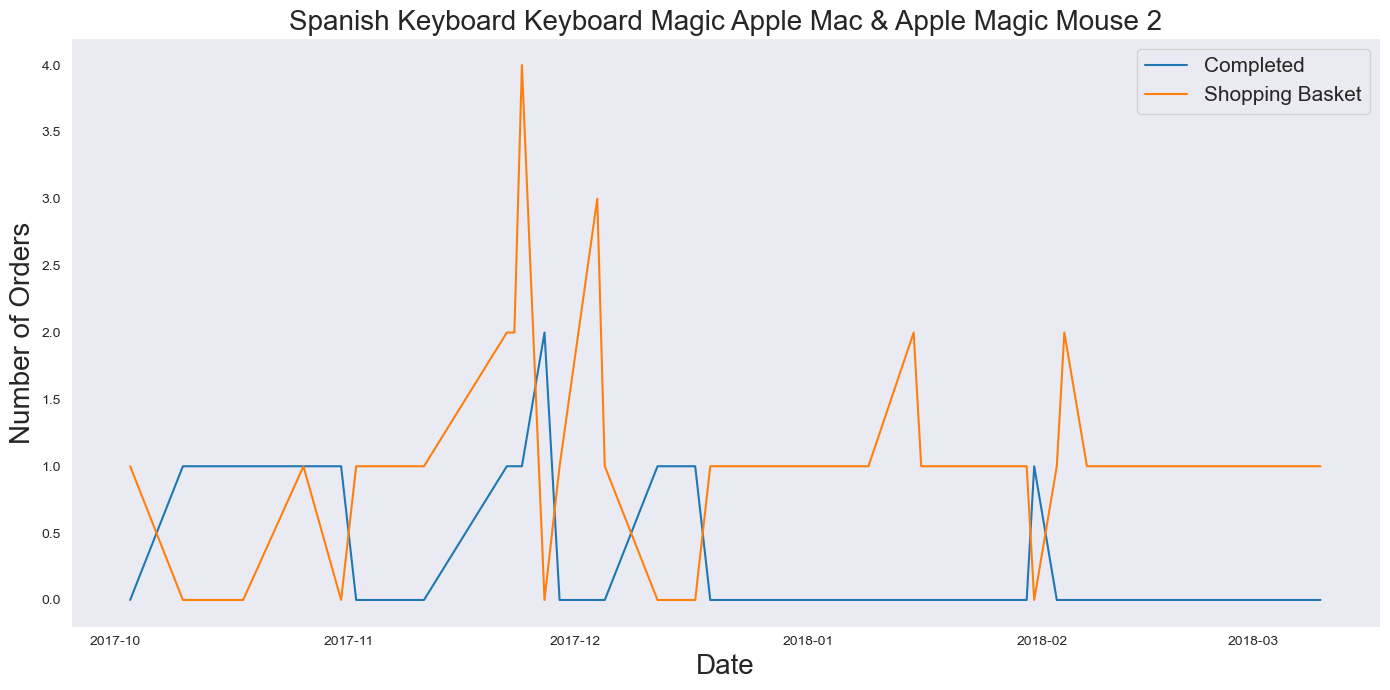

In [100]:
# Filter out rows based on id_c being not NaN and then further based on state.
df1_id_c = df1.loc[pd.notna(df1['id_c'])]
df1_id_sh = df1_id_c[df1_id_c['state'] == 'Shopping Basket'].copy()
df1_id_cc = df1_id_c[df1_id_c['state'] == 'Completed'].copy()

# Convert 'created_date' to datetime
df1_id_sh['created_date'] = pd.to_datetime(df1_id_sh['created_date'])
df1_id_cc['created_date'] = pd.to_datetime(df1_id_cc['created_date'])

# Filter out rows where id_c == 1
df1_id_sh = df1_id_sh[df1_id_sh['id_c'] == 1]
df1_id_cc = df1_id_cc[df1_id_cc['id_c'] == 1]

# Group by week and get order counts
# weekly_counts_sh = df1_id_sh.groupby(pd.Grouper(key='created_date', freq='D')).size().reset_index(name='Shopping Basket Count')
# weekly_counts_cc = df1_id_cc.groupby(pd.Grouper(key='created_date', freq='D')).size().reset_index(name='Completed Count')

weekly_counts_sh = (df1_id_sh.groupby([pd.Grouper(key='created_date', freq='D'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Shopping Basket Count'))

weekly_counts_cc = (df1_id_cc.groupby([pd.Grouper(key='created_date', freq='D'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Completed Count'))

# Merge dataframes
weekly_counts = pd.merge(weekly_counts_sh, weekly_counts_cc, on='created_date', how='outer').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='created_date', y='Completed Count', data=weekly_counts, label='Completed')
sns.lineplot(x='created_date', y='Shopping Basket Count', data=weekly_counts, label='Shopping Basket')
plt.title('Spanish Keyboard Keyboard Magic Apple Mac & Apple Magic Mouse 2', fontsize=20) # change this to the product names
plt.ylabel('Number of Orders', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.legend(prop={'size': 15})
plt.tight_layout()
plt.show()

# Let me use this for now. I want to add a line with the promotion price here, theaverage for those orders. 
# 

In [92]:
df1_id_cc.loc[df1_id_cc['id_c']==1][['id_c', 'name', 'grouped']].sample(5)

,id_c,name,grouped
40972,1,Apple iPhone 64GB Space Gray 8,"Apple iPhone 64GB Space Gray 8,IPhone AppleCar..."
46038,1,Apple iPhone 64GB Space Gray 8,"Apple iPhone 64GB Space Gray 8,IPhone AppleCar..."
47917,1,Apple iPhone 64GB Space Gray 8,"Apple iPhone 64GB Space Gray 8,IPhone AppleCar..."
55049,1,Apple iPhone 64GB Space Gray 8,"Apple iPhone 64GB Space Gray 8,IPhone AppleCar..."
73812,1,IPhone AppleCare Protection Plan,"Apple iPhone 64GB Space Gray 8,IPhone AppleCar..."


In [107]:
import re
df1['id_c']= 0

# Create a pattern to match either product regardless of the order
pattern = r"Spanish Keyboard Keyboard Magic Apple Mac|Apple Magic Mouse 2"

# Assign ID of 1 to orders containing either of the products
df1.loc[df1['grouped'].str.contains(pattern, flags=re.IGNORECASE, na=False), 'id_c'] = 1


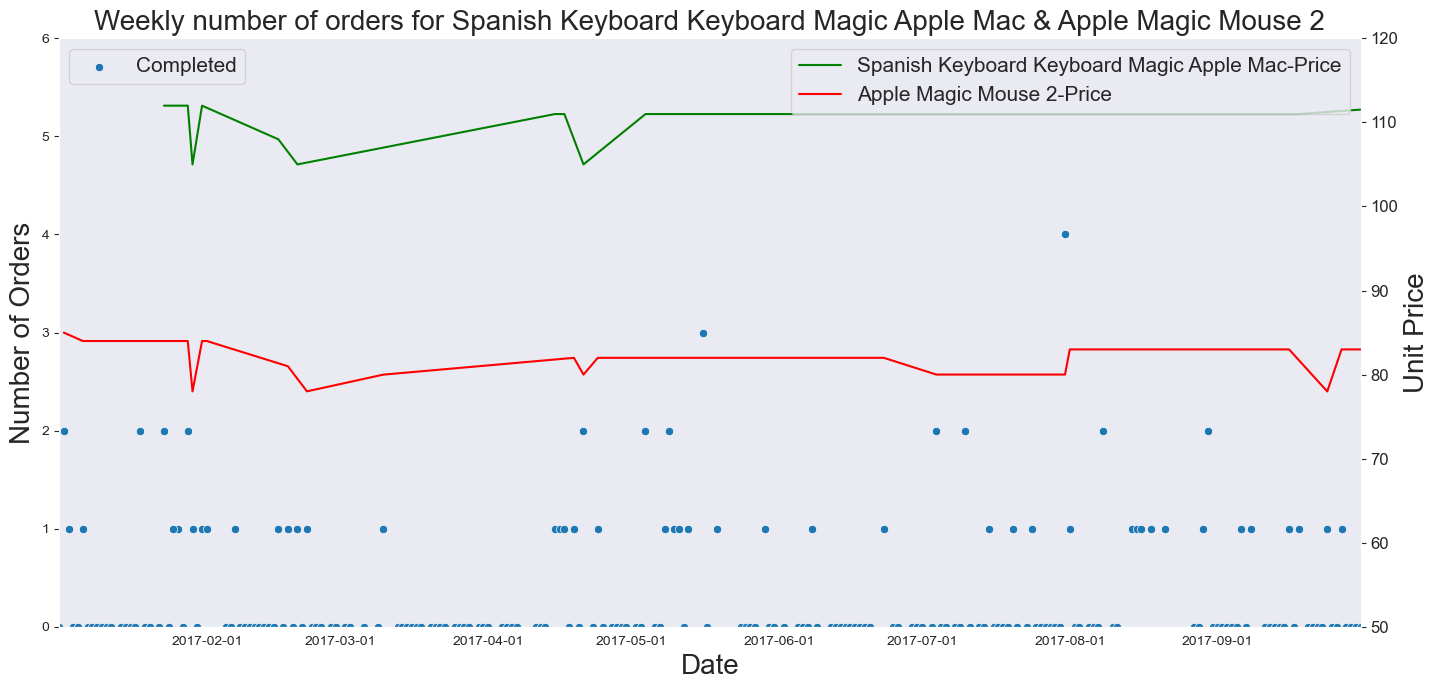

In [109]:
# Filter out rows based on id_c being not NaN and then further based on state.
df1_id_c = df1.loc[pd.notna(df1['id_c'])]
df1_id_sh = df1_id_c[df1_id_c['state'] == 'Shopping Basket'].copy()
df1_id_cc = df1_id_c[df1_id_c['state'] == 'Completed'].copy()

# Convert 'created_date' to datetime
df1_id_sh['created_date'] = pd.to_datetime(df1_id_sh['created_date'])
df1_id_cc['created_date'] = pd.to_datetime(df1_id_cc['created_date'])

# Filter out rows where id_c == 1
df1_id_sh = df1_id_sh[df1_id_sh['id_c'] == 1]
df1_id_cc = df1_id_cc[df1_id_cc['id_c'] == 1]

# get average prices
avg_prices_new = df1_id_cc.groupby([pd.Grouper(key='created_date', freq='D'), 'name'])['unit_price'].mean()
# Filter for avg_prices_new using the multi-index
avg_prices_pr1 = avg_prices_new.loc[(slice(None), 'Spanish Keyboard Keyboard Magic Apple Mac'), ].reset_index(level=1, drop=True)
avg_prices_pr2 = avg_prices_new.loc[(slice(None), 'Apple Magic Mouse 2'), ].reset_index(level=1, drop=True)


weekly_counts_sh = (df1_id_sh.groupby([pd.Grouper(key='created_date', freq='D'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Shopping Basket Count'))

weekly_counts_cc = (df1_id_cc.groupby([pd.Grouper(key='created_date', freq='D'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Completed Count'))

# Merge dataframes
weekly_counts = pd.merge(weekly_counts_sh, weekly_counts_cc, on='created_date', how='outer').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
sns.scatterplot(x='created_date', y='Completed Count', data=weekly_counts, label='Completed')
#sns.lineplot(x='created_date', y='Shopping Basket Count', data=weekly_counts, label='Shopping Basket')
plt.title('Weekly number of orders for Spanish Keyboard Keyboard Magic Apple Mac & Apple Magic Mouse 2', fontsize=20) # change this to the product names
plt.ylabel('Number of Orders', fontsize =20)
plt.xlabel('Date', fontsize=20)
plt.legend(loc='upper left', prop={'size': 15})
plt.tight_layout()
plt.ylim([0, 6])

plt.xlim(pd.Timestamp('2017-01'), pd.Timestamp('2017-10'))
# Let me use this for now. I want to add a line with the promotion price here, theaverage for those orders. 



# Create a twin y-axis
ax2 = plt.gca().twinx()

sns.lineplot(x=avg_prices_pr1.index, y=avg_prices_pr1.values, label='Spanish Keyboard Keyboard Magic Apple Mac-Price', ax=ax2, color='g')
sns.lineplot(x=avg_prices_pr2.index, y=avg_prices_pr2.values, label='Apple Magic Mouse 2-Price', ax=ax2, color='r')

# Add ylabel for the secondary y-axis
ax2.set_ylabel('Unit Price', fontsize=20)

# Add legend for the secondary y-axis
ax2.legend(loc='upper right',prop={'size': 15})
ax2.tick_params(labelsize=12)
ax2.set_ylim([50, 120])

# ----- Insert the new code snippet here -----
# Get the current x-axis ticks
ax = plt.gca()
ticks = ax.get_xticks()

# If there are any ticks, remove the last one
if len(ticks) > 0:
    ax.set_xticks(ticks[1:-1])


plt.show()

In [ ]:
# Filter out rows based on id_c being not NaN and then further based on state.
df1_id_c = df1.loc[pd.notna(df1['id_c'])]
df1_id_sh = df1_id_c[df1_id_c['state'] == 'Shopping Basket'].copy()
df1_id_cc = df1_id_c[df1_id_c['state'] == 'Completed'].copy()

# Convert 'created_date' to datetime
df1_id_sh['created_date'] = pd.to_datetime(df1_id_sh['created_date'])
df1_id_cc['created_date'] = pd.to_datetime(df1_id_cc['created_date'])

# Filter out rows where id_c == 1
df1_id_sh = df1_id_sh[df1_id_sh['id_c'] == 1]
df1_id_cc = df1_id_cc[df1_id_cc['id_c'] == 1]

# get average prices
avg_prices_new = df1_id_cc.groupby([pd.Grouper(key='created_date', freq='D'), 'name'])['unit_price'].mean()
# Filter for avg_prices_new using the multi-index
avg_prices_pr1 = avg_prices_new.loc[(slice(None), 'Spanish Keyboard Keyboard Magic Apple Mac'), ].reset_index(level=1, drop=True)
avg_prices_pr2 = avg_prices_new.loc[(slice(None), 'Apple Magic Mouse 2'), ].reset_index(level=1, drop=True)


weekly_counts_sh = (df1_id_sh.groupby([pd.Grouper(key='created_date', freq='D'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Shopping Basket Count'))

weekly_counts_cc = (df1_id_cc.groupby([pd.Grouper(key='created_date', freq='D'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Completed Count'))

# Merge dataframes
weekly_counts = pd.merge(weekly_counts_sh, weekly_counts_cc, on='created_date', how='outer').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='created_date', y='Completed Count', data=weekly_counts, label='Completed')
sns.lineplot(x='created_date', y='Shopping Basket Count', data=weekly_counts, label='Shopping Basket')
plt.title('Weekly number of orders for Spanish Keyboard Keyboard Magic Apple Mac & Apple Magic Mouse 2', fontsize=20) # change this to the product names
plt.ylabel('Number of Orders', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.legend(loc='upper left', prop={'size': 15})
plt.tight_layout()
plt.ylim([0, 6])
plt.xlim(pd.Timestamp('2017-04-10'), pd.Timestamp('2017-06-01'))

# Let me use this for now. I want to add a line with the promotion price here, theaverage for those orders. 
ax2.tick_params(axis='both', which='major', labelsize=14)

# Create a twin y-axis
ax2 = plt.gca().twinx()

#sns.lineplot(x=avg_prices_pr1.index, y=avg_prices_pr1.values, label='Spanish Keyboard Keyboard Magic Apple Mac-Price', ax=ax2, color='g')
sns.lineplot(x=avg_prices_pr2.index, y=avg_prices_pr2.values, label='Apple Magic Mouse 2-Price', ax=ax2, color='r')

# Add ylabel for the secondary y-axis
ax2.set_ylabel('Unit Price', fontsize=20)

# Add legend for the secondary y-axis
ax2.legend(loc='upper right')
ax2.legend(prop={'size': 15})
ax2.tick_params(labelsize=12)
ax2.set_ylim([75, 83])
plt.savefig('orders_zoomed.png', dpi=300, bbox_inches='tight')
plt.show()

#### 4.5.1 Some graphs

In [ ]:
# 1. Filter the data for the specific item
filtered_df = df_sh[df_sh['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the weekly mean unit price
weekly_unit_price_mean = filtered_df.resample('W', on='created_date')['unit_price'].mean().reset_index()

# Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[df_sh['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the weekly sum of product quantities in the shopping basket
weekly_product_quantity_sum = filtered_df_sh.resample('W', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[df_compl['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the weekly sum of product quantities actually bought
weekly_product_quantity_bought = filtered_df_compl.resample('W', on='created_date')['product_quantity'].sum().reset_index()

# 3. Plot the graph using Seaborn for mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis
sns.lineplot(data=weekly_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# Create a twin y-axis for the quantity sum in the shopping basket and plot
ax2 = ax1.twinx()
sns.lineplot(data=weekly_product_quantity_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='r', label='Product Quantity (Basket)')

# Create a third y-axis for the quantity actually bought and plot
ax3 = ax1.twinx()
# Offset the third axis to the right
ax3.spines['right'].set_position(('outward', 60))
sns.lineplot(data=weekly_product_quantity_bought, x='created_date', y='product_quantity', ax=ax3, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Mean Unit Price, Basket, and Bought Product Quantity of IPhone AppleCare Protection Plan Over Time (Weekly)')
ax1.set_xlabel('Month.Year')
ax1.set_ylabel('Mean Unit Price')
ax2.set_ylabel('Product Quantity (Basket)')
ax3.set_ylabel('Product Quantity (Bought)')

ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust x-axis ticks to show the beginning of every month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))  # Format x-axis ticks to show month.year
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='center right')

plt.tight_layout()
plt.show()


In [ ]:
# 1. Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[df_sh['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the weekly mean unit price and sum of product quantities in the shopping basket
weekly_unit_price_mean = filtered_df_sh.resample('W', on='created_date')['unit_price'].mean().reset_index()
weekly_product_quantity_sh_sum = filtered_df_sh.resample('W', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[df_compl['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the weekly sum of product quantities actually bought
weekly_product_quantity_compl_sum = filtered_df_compl.resample('W', on='created_date')['product_quantity'].sum().reset_index()

# 3. Plot the graph using Seaborn for mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis
sns.lineplot(data=weekly_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# Plot the quantity sum in the shopping basket
sns.lineplot(data=weekly_product_quantity_sh_sum, x='created_date', y='product_quantity', ax=ax1, linestyle='-', color='r', label='Product Quantity (Basket)')

# Plot the quantity actually bought
sns.lineplot(data=weekly_product_quantity_compl_sum, x='created_date', y='product_quantity', ax=ax1, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Mean Unit Price, Basket, and Bought Product Quantity of IPhone AppleCare Protection Plan Over Time (Weekly)')
ax1.set_xlabel('Month.Year')
ax1.set_ylabel('Mean Unit Price / Product Quantity')

ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust x-axis ticks to show the beginning of every month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))  # Format x-axis ticks to show month.year
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# 1. Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[df_sh['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the weekly mean unit price and sum of product quantities in the shopping basket
weekly_unit_price_mean = filtered_df_sh.resample('W', on='created_date')['unit_price'].mean().reset_index()
weekly_product_quantity_sh_sum = filtered_df_sh.resample('W', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[df_compl['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the weekly sum of product quantities actually bought
weekly_product_quantity_compl_sum = filtered_df_compl.resample('W', on='created_date')['product_quantity'].sum().reset_index()

# 3. Plot the graph using Seaborn for mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis for unit_price
sns.lineplot(data=weekly_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# Create a twin y-axis for the quantity sum (both from basket and completed)
ax2 = ax1.twinx()
sns.lineplot(data=weekly_product_quantity_sh_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='r', label='Product Quantity (Basket)')
sns.lineplot(data=weekly_product_quantity_compl_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Mean Unit Price and Product Quantity of IPhone AppleCare Protection Plan Over Time (Weekly)')
ax1.set_xlabel('Month.Year')
ax1.set_ylabel('Mean Unit Price')
ax2.set_ylabel('Product Quantity')

ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust x-axis ticks to show the beginning of every month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))  # Format x-axis ticks to show month.year
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[df_sh['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the monthly mean unit price and sum of product quantities in the shopping basket
monthly_unit_price_mean = filtered_df_sh.resample('M', on='created_date')['unit_price'].mean().reset_index()
monthly_product_quantity_sh_sum = filtered_df_sh.resample('M', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[df_compl['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the monthly sum of product quantities actually bought
monthly_product_quantity_compl_sum = filtered_df_compl.resample('M', on='created_date')['product_quantity'].sum().reset_index()

# 3. Plot the graph using Seaborn for monthly mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis for unit_price
sns.lineplot(data=monthly_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# Create a twin y-axis for the quantity sum (both from basket and completed)
ax2 = ax1.twinx()
sns.lineplot(data=monthly_product_quantity_sh_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='r', label='Product Quantity (Basket)')
sns.lineplot(data=monthly_product_quantity_compl_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Monthly Mean Unit Price and Product Quantity of IPhone AppleCare Protection Plan')
ax1.set_xlabel('Month.Year')
ax1.set_ylabel('Mean Unit Price')
ax2.set_ylabel('Product Quantity')

ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust x-axis ticks to show the beginning of every month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))  # Format x-axis ticks to show month.year
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:

# 1. Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[df_sh['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the monthly mean unit price and sum of product quantities in the shopping basket
monthly_unit_price_mean = filtered_df_sh.resample('M', on='created_date')['unit_price'].mean().reset_index()
monthly_product_quantity_sh_sum = filtered_df_sh.resample('M', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[df_compl['name'] == 'IPhone AppleCare Protection Plan']

# Resample and calculate the monthly sum of product quantities actually bought
monthly_product_quantity_compl_sum = filtered_df_compl.resample('M', on='created_date')['product_quantity'].sum().reset_index()

# Plot the graph using Seaborn for monthly mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis for unit_price
sns.lineplot(data=monthly_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# Add dashed lines connecting each point to the x-axis (the bottom of the y-axis for ax1)
for x, y in zip(monthly_unit_price_mean['created_date'], monthly_unit_price_mean['unit_price']):
    ax1.plot([x, x], [y, 0], '--', color='blue')  # Adjusted the y2 value to 0 to reach the x-axis

# Create a twin y-axis for the quantity sum (both from basket and completed)
ax2 = ax1.twinx()
sns.lineplot(data=monthly_product_quantity_sh_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='r', label='Product Quantity (Basket)')
sns.lineplot(data=monthly_product_quantity_compl_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Monthly Mean Unit Price and Product Quantity of IPhone AppleCare Protection Plan')
ax1.set_xlabel('Month.Year')
ax1.set_ylabel('Mean Unit Price')
ax2.set_ylabel('Product Quantity')

ax1.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust x-axis ticks to show the beginning of every month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))  # Format x-axis ticks to show month.year
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


What we see is, when unit_price drops, almost simultaneaously the number of items in basket increases and the purchases completed as well. Now I will zoom in on a short time frame and use daily data.

In [ ]:
# 1. Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[(df_sh['name'] == 'IPhone AppleCare Protection Plan') & 
                       (df_sh['created_date'] >= '2017-07-01') & 
                       (df_sh['created_date'] <= '2017-09-30')]

# Resample and calculate the daily mean unit price and sum of product quantities in the shopping basket
daily_unit_price_mean = filtered_df_sh.resample('D', on='created_date')['unit_price'].mean().reset_index()
daily_product_quantity_sh_sum = filtered_df_sh.resample('D', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[(df_compl['name'] == 'IPhone AppleCare Protection Plan') & 
                             (df_compl['created_date'] >= '2017-07-01') & 
                             (df_compl['created_date'] <= '2017-09-30')]

# Resample and calculate the daily sum of product quantities actually bought
daily_product_quantity_compl_sum = filtered_df_compl.resample('D', on='created_date')['product_quantity'].sum().reset_index()

# Plot the graph using Seaborn for daily mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis for unit_price
sns.lineplot(data=daily_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# # Add dashed lines connecting each point to the x-axis
# for x, y in zip(daily_unit_price_mean['created_date'], daily_unit_price_mean['unit_price']):
#     ax1.plot([x, x], [y, 0], '--', color='blue')  # Adjusted the y2 value to 0 to reach the x-axis

# Create a twin y-axis for the quantity sum (both from basket and completed)
ax2 = ax1.twinx()
sns.lineplot(data=daily_product_quantity_sh_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='r', label='Product Quantity (Basket)')
sns.lineplot(data=daily_product_quantity_compl_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Daily Mean Unit Price and Product Quantity of IPhone AppleCare Protection Plan (07.17 - 09.17)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Mean Unit Price')
ax2.set_ylabel('Product Quantity')

ax1.xaxis.set_major_locator(mdates.WeekdayLocator())  # Adjust x-axis ticks to show every day of the week
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d'))  # Format x-axis ticks to show month.day
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[(df_sh['name'] == 'IPhone AppleCare Protection Plan') & 
                       (df_sh['created_date'] >= '2017-07-15') & 
                       (df_sh['created_date'] <= '2017-08-01')]

# Resample and calculate the daily mean unit price and sum of product quantities in the shopping basket
daily_unit_price_mean = filtered_df_sh.resample('D', on='created_date')['unit_price'].mean().reset_index()
daily_product_quantity_sh_sum = filtered_df_sh.resample('D', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[(df_compl['name'] == 'IPhone AppleCare Protection Plan') & 
                             (df_compl['created_date'] >= '2017-07-15') & 
                             (df_compl['created_date'] <= '2017-08-01')]

# Resample and calculate the daily sum of product quantities actually bought
daily_product_quantity_compl_sum = filtered_df_compl.resample('D', on='created_date')['product_quantity'].sum().reset_index()

# Plot the graph using Seaborn for daily mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis for unit_price
sns.lineplot(data=daily_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# # Add dashed lines connecting each point to the x-axis
# for x, y in zip(daily_unit_price_mean['created_date'], daily_unit_price_mean['unit_price']):
#     ax1.plot([x, x], [y, 0], '--', color='blue')  # Adjusted the y2 value to 0 to reach the x-axis

# Create a twin y-axis for the quantity sum (both from basket and completed)
ax2 = ax1.twinx()
sns.lineplot(data=daily_product_quantity_sh_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='r', label='Product Quantity (Basket)')
sns.lineplot(data=daily_product_quantity_compl_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Daily Mean Unit Price and Product Quantity of IPhone AppleCare Protection Plan (15.07.17 - 01.08.17)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Mean Unit Price')
ax2.set_ylabel('Product Quantity')

ax1.xaxis.set_major_locator(mdates.DayLocator())  # Adjust x-axis ticks to show every day
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))  # Format x-axis ticks to show day.month
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[(df_sh['name'] == 'IPhone AppleCare Protection Plan') & 
                       (df_sh['created_date'] >= '2017-11-01') & 
                       (df_sh['created_date'] <= '2017-11-30')]

# Resample and calculate the daily mean unit price and sum of product quantities in the shopping basket
daily_unit_price_mean = filtered_df_sh.resample('D', on='created_date')['unit_price'].mean().reset_index()
daily_product_quantity_sh_sum = filtered_df_sh.resample('D', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[(df_compl['name'] == 'IPhone AppleCare Protection Plan') & 
                             (df_compl['created_date'] >= '2017-11-01') & 
                             (df_compl['created_date'] <= '2017-11-30')]

# Resample and calculate the daily sum of product quantities actually bought
daily_product_quantity_compl_sum = filtered_df_compl.resample('D', on='created_date')['product_quantity'].sum().reset_index()

# Plot the graph using Seaborn for daily mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis for unit_price
sns.lineplot(data=daily_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# # Add dashed lines connecting each point to the x-axis
# for x, y in zip(daily_unit_price_mean['created_date'], daily_unit_price_mean['unit_price']):
#     ax1.plot([x, x], [y, 0], '--', color='blue')  # Adjusted the y2 value to 0 to reach the x-axis

# Create a twin y-axis for the quantity sum (both from basket and completed)
ax2 = ax1.twinx()
sns.lineplot(data=daily_product_quantity_sh_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='r', label='Product Quantity (Basket)')
sns.lineplot(data=daily_product_quantity_compl_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Daily Mean Unit Price and Product Quantity of IPhone AppleCare Protection Plan (November 2017)')
ax1.set_xlabel('Date (November 2017)')
ax1.set_ylabel('Mean Unit Price')
ax2.set_ylabel('Product Quantity')

ax1.xaxis.set_major_locator(mdates.DayLocator())  # Adjust x-axis ticks to show every day
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))  # Format x-axis ticks to show day.month
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[(df_sh['name'] == 'IPhone AppleCare Protection Plan') & 
                       (df_sh['created_date'] >= '2017-11-01') & 
                       (df_sh['created_date'] <= '2017-11-30')]

# Resample and calculate the weekly mean unit price and sum of product quantities in the shopping basket
weekly_unit_price_mean = filtered_df_sh.resample('W-MON', on='created_date')['unit_price'].mean().reset_index()
weekly_product_quantity_sh_sum = filtered_df_sh.resample('W-MON', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[(df_compl['name'] == 'IPhone AppleCare Protection Plan') & 
                             (df_compl['created_date'] >= '2017-11-01') & 
                             (df_compl['created_date'] <= '2017-11-30')]

# Resample and calculate the weekly sum of product quantities actually bought
weekly_product_quantity_compl_sum = filtered_df_compl.resample('W-MON', on='created_date')['product_quantity'].sum().reset_index()

# Plot the graph using Seaborn for weekly mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis for unit_price
sns.lineplot(data=weekly_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# Add dashed lines connecting each point to the x-axis
for x, y in zip(weekly_unit_price_mean['created_date'], weekly_unit_price_mean['unit_price']):
    ax1.plot([x, x], [y, 0], '--', color='blue')  # Adjusted the y2 value to 0 to reach the x-axis

# Create a twin y-axis for the quantity sum (both from basket and completed)
ax2 = ax1.twinx()
sns.lineplot(data=weekly_product_quantity_sh_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='r', label='Product Quantity (Basket)')
sns.lineplot(data=weekly_product_quantity_compl_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Weekly Mean Unit Price and Product Quantity of IPhone AppleCare Protection Plan (November 2017)')
ax1.set_xlabel('Week (November 2017)')
ax1.set_ylabel('Mean Unit Price')
ax2.set_ylabel('Product Quantity')

ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))  # Adjust x-axis ticks to show every week's starting day, i.e., Monday
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))  # Format x-axis ticks to show day.month
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Filter the data for the specific item from df_sh
filtered_df_sh = df_sh[(df_sh['name'] == 'IPhone AppleCare Protection Plan') & 
                       (df_sh['created_date'] >= '2017-11-23') & 
                       (df_sh['created_date'] <= '2017-11-25')]

# Resample and calculate the hourly mean unit price and sum of product quantities in the shopping basket
hourly_unit_price_mean = filtered_df_sh.resample('H', on='created_date')['unit_price'].mean().reset_index()
hourly_product_quantity_sh_sum = filtered_df_sh.resample('H', on='created_date')['product_quantity'].sum().reset_index()

# Filter the data for the specific item from df_compl
filtered_df_compl = df_compl[(df_compl['name'] == 'IPhone AppleCare Protection Plan') & 
                             (df_compl['created_date'] >= '2017-11-23') & 
                             (df_compl['created_date'] <= '2017-11-25')]

# Resample and calculate the hourly sum of product quantities actually bought
hourly_product_quantity_compl_sum = filtered_df_compl.resample('H', on='created_date')['product_quantity'].sum().reset_index()

# Plot the graph using Seaborn for hourly mean unit price
plt.figure(figsize=(14, 8))
ax1 = plt.gca()  # Get current axis for unit_price
sns.lineplot(data=hourly_unit_price_mean, x='created_date', y='unit_price', ax=ax1, linestyle='-', label='Mean Unit Price')

# # Add dashed lines connecting each point to the x-axis
# for x, y in zip(hourly_unit_price_mean['created_date'], hourly_unit_price_mean['unit_price']):
#     ax1.plot([x, x], [y, 0], '--', color='blue')

# Create a twin y-axis for the quantity sum (both from basket and completed)
ax2 = ax1.twinx()
sns.lineplot(data=hourly_product_quantity_sh_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='r', label='Product Quantity (Basket)')
sns.lineplot(data=hourly_product_quantity_compl_sum, x='created_date', y='product_quantity', ax=ax2, linestyle='-', color='g', label='Product Quantity (Bought)')

# Formatting
ax1.set_title('Hourly Mean Unit Price and Product Quantity of IPhone AppleCare Protection Plan (23-25 November 2017)')
ax1.set_xlabel('Hour (23-25 November 2017)')
ax1.set_ylabel('Mean Unit Price')
ax2.set_ylabel('Product Quantity')

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Adjust x-axis ticks to show every hour
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format x-axis ticks to show hour:minute
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


WHat I want is: a graph over time, showing how many of these product combinations were in the basket one day, and bought another day.

In [94]:
# Filter out rows based on id_c being not NaN and then further based on state.
df1_id_c = df1.loc[pd.notna(df1['id_c'])]
df1_id_sh = df1_id_c[df1_id_c['state'] == 'Shopping Basket'].copy()
df1_id_cc = df1_id_c[df1_id_c['state'] == 'Completed'].copy()

# Convert 'created_date' to datetime
df1_id_sh['created_date'] = pd.to_datetime(df1_id_sh['created_date'])
df1_id_cc['created_date'] = pd.to_datetime(df1_id_cc['created_date'])

# Filter for the date range
start_date = '2017-04-10'
end_date = '2017-06-01'
mask_sh = (df1_id_sh['created_date'] >= start_date) & (df1_id_sh['created_date'] <= end_date)
mask_cc = (df1_id_cc['created_date'] >= start_date) & (df1_id_cc['created_date'] <= end_date)

df1_id_sh = df1_id_sh[mask_sh]
df1_id_cc = df1_id_cc[mask_cc]

# Filter out rows where id_c == 1
df1_id_sh = df1_id_sh[df1_id_sh['id_c'] == 1]
df1_id_cc = df1_id_cc[df1_id_cc['id_c'] == 1]

# get average prices
avg_prices_new = df1_id_cc.groupby([pd.Grouper(key='created_date', freq='D'), 'name'])['unit_price'].mean()
# Filter for avg_prices_new using the multi-index
avg_prices_pr1 = avg_prices_new.loc[(slice(None), 'Spanish Keyboard Keyboard Magic Apple Mac'), ].reset_index(level=1, drop=True)
avg_prices_pr2 = avg_prices_new.loc[(slice(None), 'Apple Magic Mouse 2'), ].reset_index(level=1, drop=True)


weekly_counts_sh = (df1_id_sh.groupby([pd.Grouper(key='created_date', freq='D'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Shopping Basket Count'))

weekly_counts_cc = (df1_id_cc.groupby([pd.Grouper(key='created_date', freq='D'), 'order_id'])
                    .size()
                    .reset_index(name='Counts')
                    .groupby('created_date')
                    .size()
                    .reset_index(name='Completed Count'))

# Merge dataframes
weekly_counts = pd.merge(weekly_counts_sh, weekly_counts_cc, on='created_date', how='outer').fillna(0)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='created_date', y='Completed Count', data=weekly_counts, label='Completed')
sns.lineplot(x='created_date', y='Shopping Basket Count', data=weekly_counts, label='Shopping Basket')
plt.title('Weekly number of orders for Spanish Keyboard Keyboard Magic Apple Mac & Apple Magic Mouse 2') # change this to the product names
plt.ylabel('Number of Orders')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim([0, 4])
#plt.xlim(['10.04.2017', '01.06.2017'])


# Let me use this for now. I want to add a line with the promotion price here, theaverage for those orders. 


# Create a twin y-axis
ax2 = plt.gca().twinx()

#sns.lineplot(x=avg_prices_pr1.index, y=avg_prices_pr1.values, label='Spanish Keyboard Keyboard Magic Apple Mac-Price', ax=ax2, color='g')
sns.lineplot(x=avg_prices_pr2.index, y=avg_prices_pr2.values, label='Apple Magic Mouse 2-Price', ax=ax2, color='r')

# Add ylabel for the secondary y-axis
ax2.set_ylabel('Unit Price')

# Add legend for the secondary y-axis
ax2.legend(loc='upper right')
ax2.set_ylim([70, 86])
plt.savefig('orders_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'Spanish Keyboard Keyboard Magic Apple Mac'

## This worked

In [ ]:
print('This worked well. Congratulations')